In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv("runs_artifact/knowledge_08_01:28:19_harmonesuccess/predictions.csv")

# Preview
df.head()


,image_name,confidence,model_used,inference_time,energy_uJ,histogram
0,0000f77c-6257be58.jpg,0.779603,yolo_m,1.160300,26654900.0,0.00014540 0.00860894 0.00634766 0.00493598 0....
1,0000f77c-62c2a288.jpg,0.577856,yolo_m,0.181534,3861318.0,0.00104058 0.01715603 0.00833116 0.01624674 0....
2,0000f77c-cb820c98.jpg,0.698048,yolo_m,0.181301,3851553.0,0.00169922 0.02040256 0.00924805 0.03906467 0....
3,0001542f-5ce3cf52.jpg,0.357149,yolo_m,0.180580,3742300.0,0.00001845 0.00064670 0.00388997 0.03072808 0....
4,0001542f-7c670be8.jpg,0.456391,yolo_m,0.183736,3871328.0,0.00000217 0.00004991 0.00074870 0.01040582 0....


In [3]:
# Overall stats
overall_stats = {
    "avg_confidence": df["confidence"].mean(),
    "avg_energy": df["energy_uJ"].mean(),
    "avg_inference_time": df["inference_time"].mean(),
    "count": len(df)
}

print("Overall Stats:")
print(overall_stats)

# Per-model stats
per_model_stats = df.groupby("model_used").agg({
    "confidence": "mean",
    "energy_uJ": "mean",
    "inference_time": "mean",
    "image_name": "count"
}).rename(columns={"image_name": "count"})

print("\nPer-Model Stats:")
print(per_model_stats)


Overall Stats:
{'avg_confidence': np.float64(0.5487009997201817), 'avg_energy': np.float64(2486374.8588571427), 'avg_inference_time': np.float64(0.10618380621841975), 'count': 70000}

Per-Model Stats:
            confidence     energy_uJ  inference_time  count
model_used                                                 
yolo_m        0.565031  4.264315e+06        0.192786  12929
yolo_n        0.536250  1.493609e+06        0.060033  23608
yolo_s        0.551176  2.499829e+06        0.105282  33463


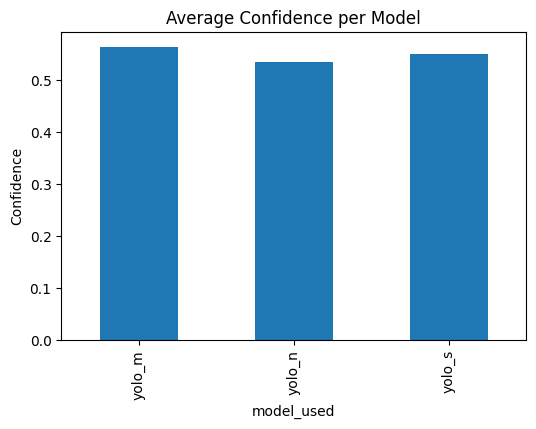

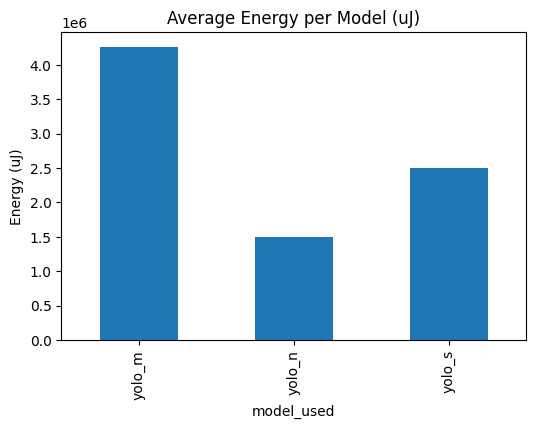

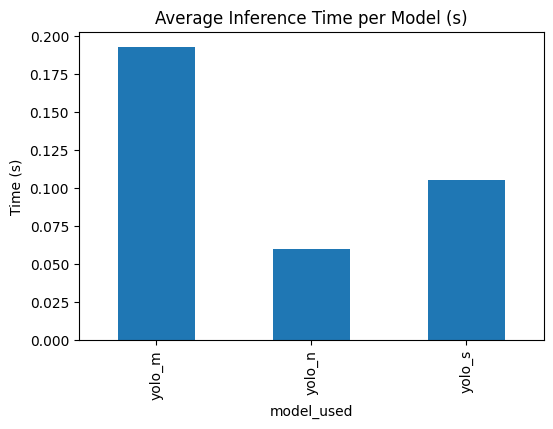

In [4]:
# Avg confidence per model
per_model_stats["confidence"].plot(kind="bar", figsize=(6,4), title="Average Confidence per Model")
plt.ylabel("Confidence")
plt.show()

# Avg energy per model
per_model_stats["energy_uJ"].plot(kind="bar", figsize=(6,4), title="Average Energy per Model (uJ)")
plt.ylabel("Energy (uJ)")
plt.show()

# Avg inference time per model
per_model_stats["inference_time"].plot(kind="bar", figsize=(6,4), title="Average Inference Time per Model (s)")
plt.ylabel("Time (s)")
plt.show()


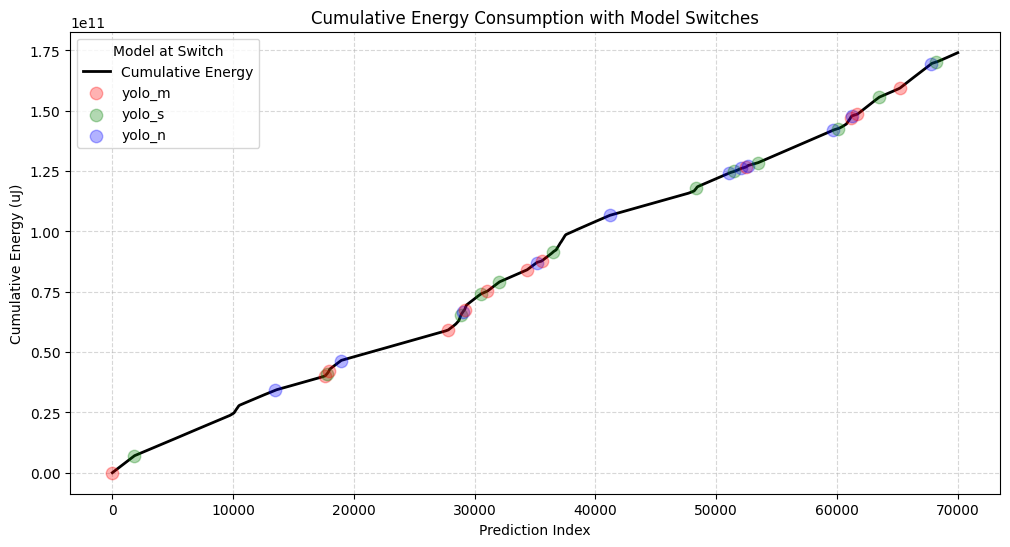

In [5]:
import numpy as np

# Compute cumulative energy
df["cumulative_energy"] = df["energy_uJ"].cumsum()

plt.figure(figsize=(12,6))

# Plot the cumulative line
plt.plot(df.index, df["cumulative_energy"], color="black", linewidth=2, label="Cumulative Energy")

# Detect model switches
switch_indices = df.index[df["model_used"].shift() != df["model_used"]].tolist()

# Define colors for models
model_colors = {"yolo_n": "blue", "yolo_s": "green", "yolo_m": "red"}

# Add colored dots at switch points
for idx in switch_indices:
    model = df.loc[idx, "model_used"]
    plt.scatter(
        idx,
        df.loc[idx, "cumulative_energy"],
        color=model_colors[model],
        s=80,
        zorder=5,
        label=model if f"dot_{model}" not in locals() else "",  # avoid duplicate legend entries
        alpha=0.3
    )
    locals()[f"dot_{model}"] = True  # mark legend entry done

plt.title("Cumulative Energy Consumption with Model Switches")
plt.xlabel("Prediction Index")
plt.ylabel("Cumulative Energy (uJ)")
plt.legend(title="Model at Switch", loc="upper left")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


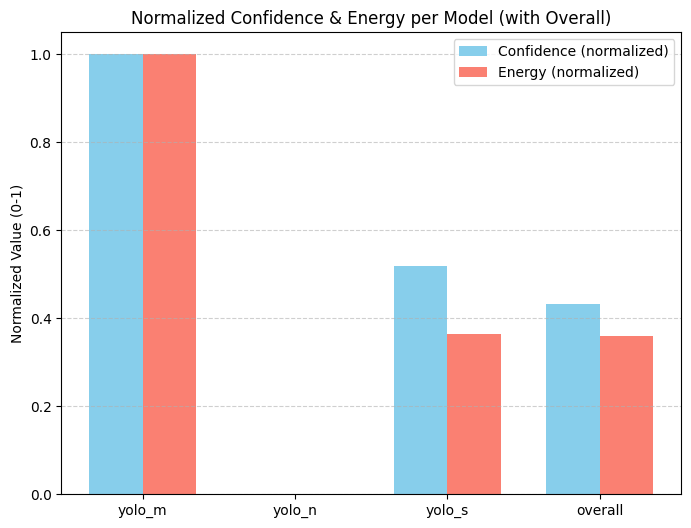

In [6]:
import numpy as np

# Prepare per-model stats again
per_model_stats = df.groupby("model_used").agg({
    "confidence": "mean",
    "energy_uJ": "mean"
})

# Add overall stats
overall_row = pd.DataFrame({
    "confidence": [df["confidence"].mean()],
    "energy_uJ": [df["energy_uJ"].mean()]
}, index=["overall"])

stats_combined = pd.concat([per_model_stats, overall_row])

# Normalize both columns to 0–1 range
stats_norm = stats_combined.copy()
stats_norm["confidence"] = (stats_norm["confidence"] - stats_norm["confidence"].min()) / (stats_norm["confidence"].max() - stats_norm["confidence"].min())
stats_norm["energy_uJ"] = (stats_norm["energy_uJ"] - stats_norm["energy_uJ"].min()) / (stats_norm["energy_uJ"].max() - stats_norm["energy_uJ"].min())

# Plot grouped bars
x = np.arange(len(stats_norm))  # positions
width = 0.35  # bar width

plt.figure(figsize=(8,6))
plt.bar(x - width/2, stats_norm["confidence"], width, label="Confidence (normalized)", color="skyblue")
plt.bar(x + width/2, stats_norm["energy_uJ"], width, label="Energy (normalized)", color="salmon")

# Labels
plt.xticks(x, stats_norm.index)
plt.title("Normalized Confidence & Energy per Model (with Overall)")
plt.ylabel("Normalized Value (0-1)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()


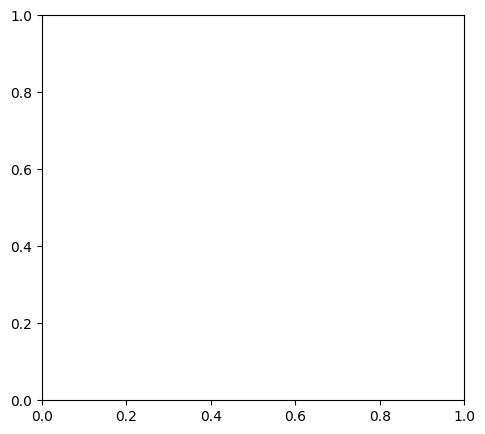

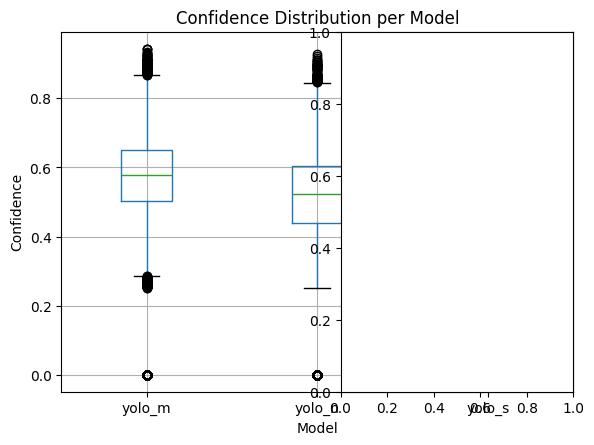

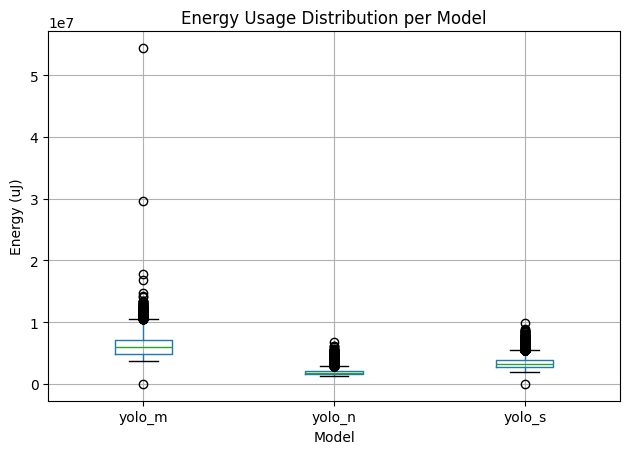

In [39]:
plt.figure(figsize=(12,5))

# Confidence distribution per model
plt.subplot(1,2,1)
df.boxplot(column="confidence", by="model_used")
plt.title("Confidence Distribution per Model")
plt.suptitle("")
plt.xlabel("Model")
plt.ylabel("Confidence")

# Energy distribution per model
plt.subplot(1,2,2)
df.boxplot(column="energy_uJ", by="model_used")
plt.title("Energy Usage Distribution per Model")
plt.suptitle("")
plt.xlabel("Model")
plt.ylabel("Energy (uJ)")

plt.tight_layout()
plt.show()


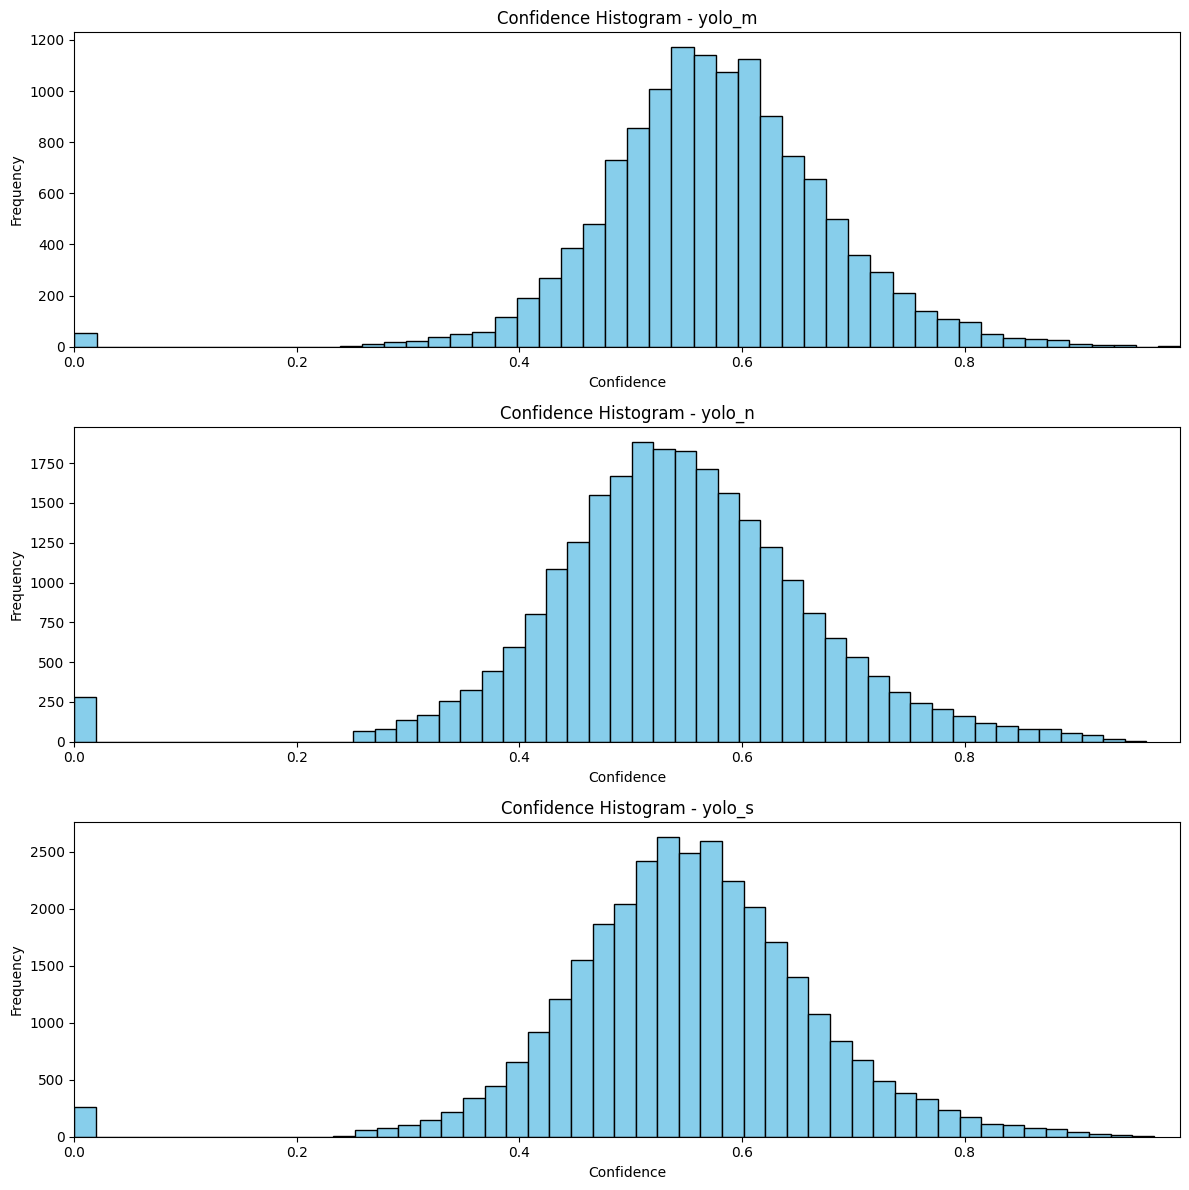

In [8]:
models = df["model_used"].unique()

# Get global min/max for confidence
conf_min, conf_max = df["confidence"].min(), df["confidence"].max()

plt.figure(figsize=(12, 4 * len(models)))

for i, model in enumerate(models, 1):
    subset = df[df["model_used"] == model]
    plt.subplot(len(models), 1, i)
    plt.hist(subset["confidence"], bins=50, color="skyblue", edgecolor="black")
    plt.xlim(conf_min, conf_max)
    plt.title(f"Confidence Histogram - {model}")
    plt.xlabel("Confidence")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


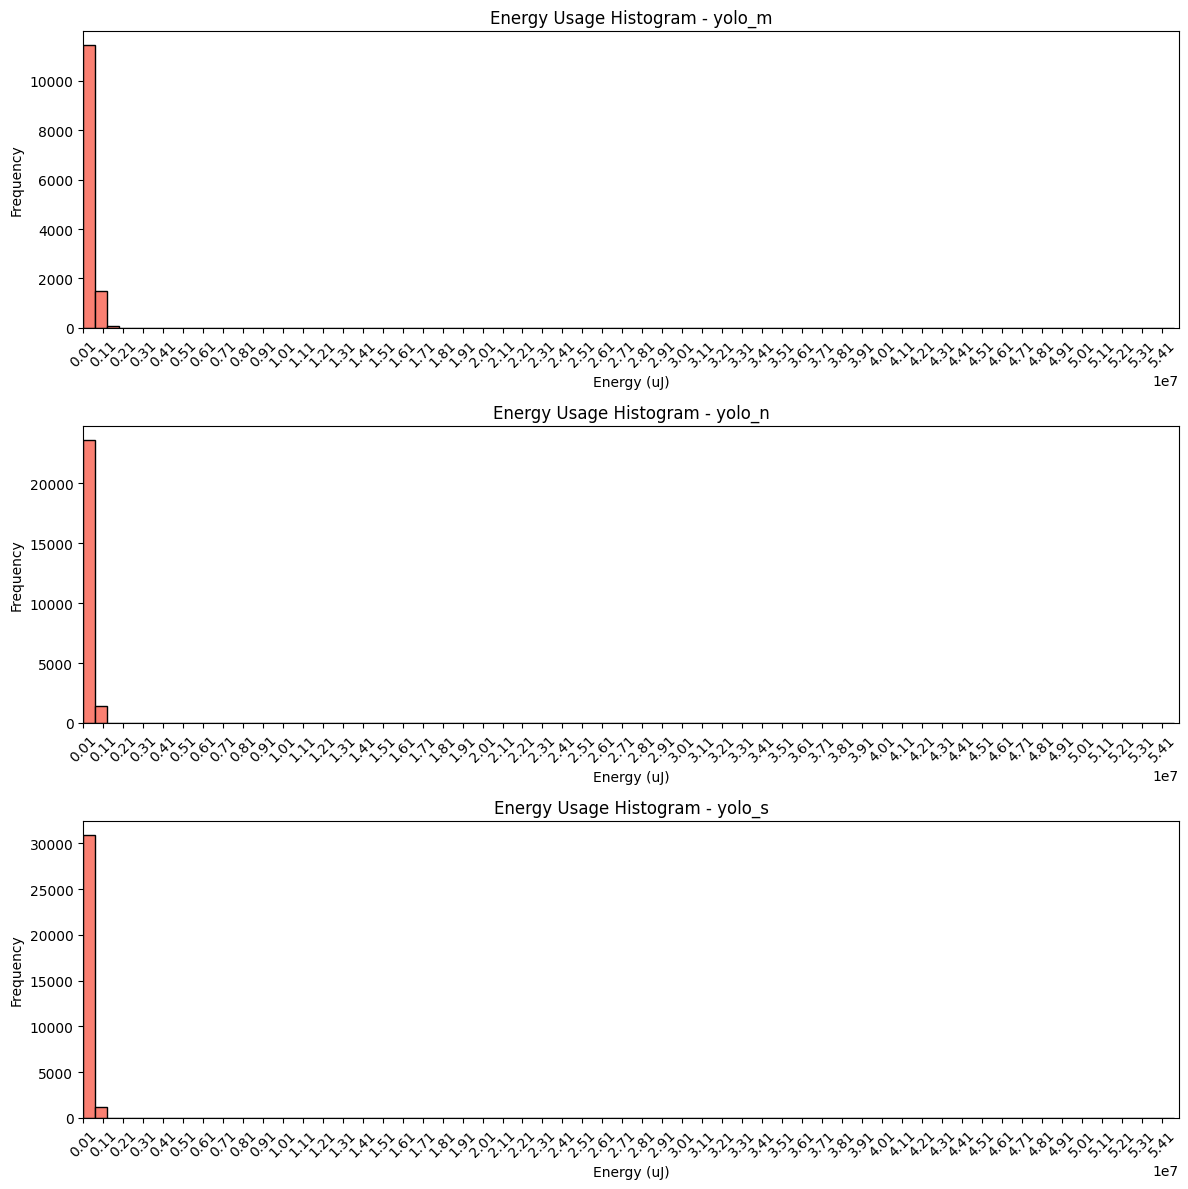

In [14]:
# Get global min/max for energy
energy_min, energy_max = df["energy_uJ"].min(), df["energy_uJ"].max()

plt.figure(figsize=(12, 4 * len(models)))

for i, model in enumerate(models, 1):
    subset = df[df["model_used"] == model]
    plt.subplot(len(models), 1, i)
    plt.hist(subset["energy_uJ"], bins=np.arange(energy_min, energy_max + 1, 600000), color="salmon", edgecolor="black")
    plt.xticks(np.arange(energy_min, energy_max + 1, 1000000), rotation=45)
    plt.xlim(energy_min, energy_max)
    plt.title(f"Energy Usage Histogram - {model}")
    plt.xlabel("Energy (uJ)")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [42]:
import pandas as pd

# Load the CSV
df = pd.read_csv("knowledge/avg_conf_time_energy_by_block.csv")

# Each row represents a block of 100 frames (start_idx to end_idx)
# We want averages over 10k intervals -> 20 rows = 20 * 500 frames = 10k
block_size = 20

results = []

for model, group in df.groupby("model"):
    group = group.reset_index(drop=True)
    
    # Assign 10k intervals (0–10k, 10k–20k, ...)
    group["interval"] = (group.index // block_size) * 10000
    
    # Compute average confidence for each interval
    avg_conf_by_interval = group.groupby("interval")["avg_conf"].mean().reset_index()
    avg_conf_by_interval["model"] = model
    
    results.append(avg_conf_by_interval)

# Combine all models
final_df = pd.concat(results, ignore_index=True)

# Rearrange columns for clarity
final_df = final_df[["model", "interval", "avg_conf"]]


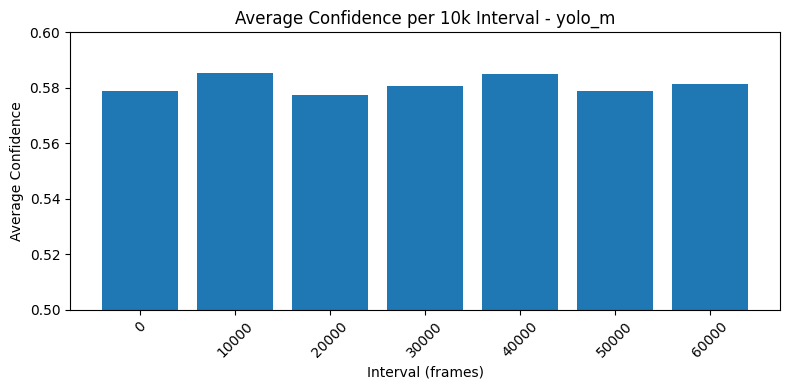

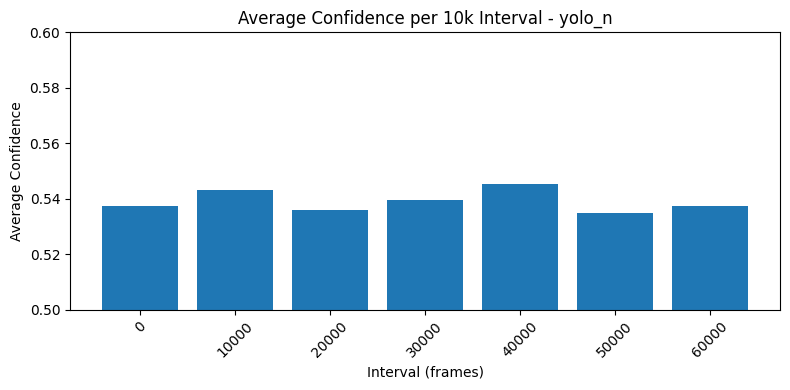

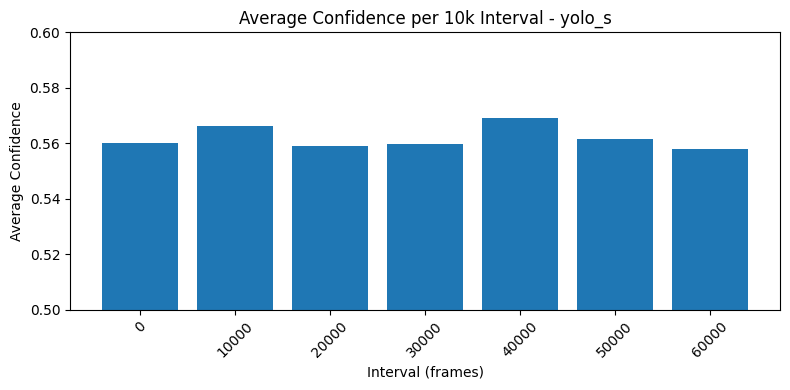

In [43]:
import matplotlib.pyplot as plt

# Ensure intervals are sorted numerically
final_df["interval"] = final_df["interval"].astype(int)

models = final_df["model"].unique()

for model in models:
    subset = final_df[final_df["model"] == model]
    
    plt.figure(figsize=(8,4))
    plt.bar(subset["interval"].astype(str), subset["avg_conf"])
    plt.title(f"Average Confidence per 10k Interval - {model}")
    plt.ylim(0.5, 0.6)
    plt.xlabel("Interval (frames)")
    plt.ylabel("Average Confidence")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


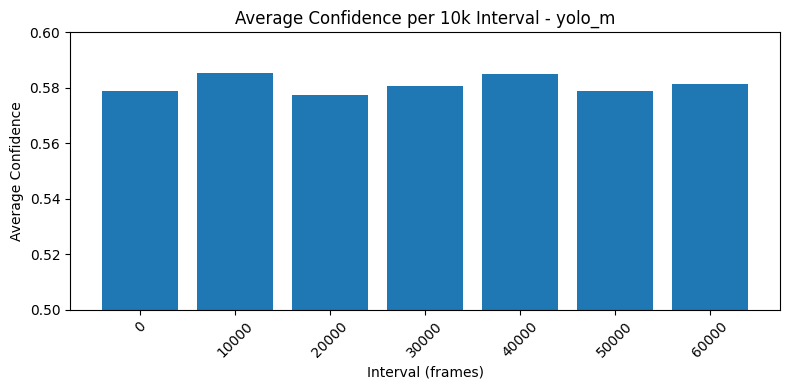

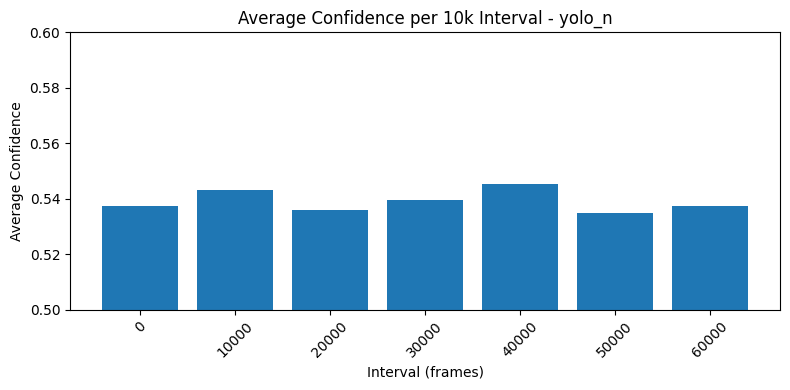

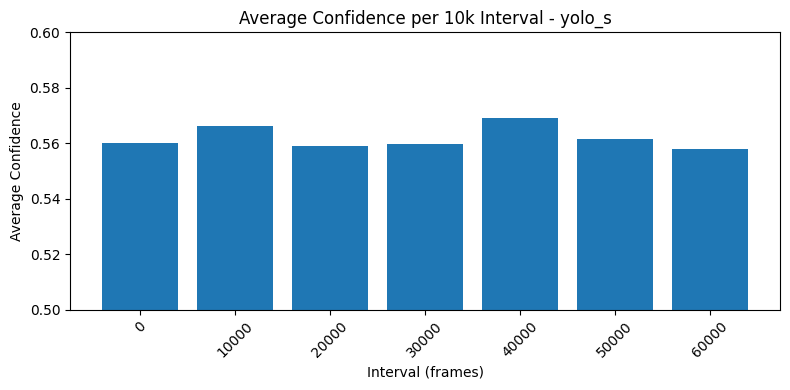

In [44]:
import matplotlib.pyplot as plt

# Ensure intervals are sorted numerically
final_df["interval"] = final_df["interval"].astype(int)

models = final_df["model"].unique()

for model in models:
    subset = final_df[final_df["model"] == model]
    
    plt.figure(figsize=(8,4))
    plt.bar(subset["interval"].astype(str), subset["avg_conf"])
    plt.title(f"Average Confidence per 10k Interval - {model}")
    plt.ylim(0.5, 0.6)
    plt.xlabel("Interval (frames)")
    plt.ylabel("Average Confidence")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


82.57043800636573


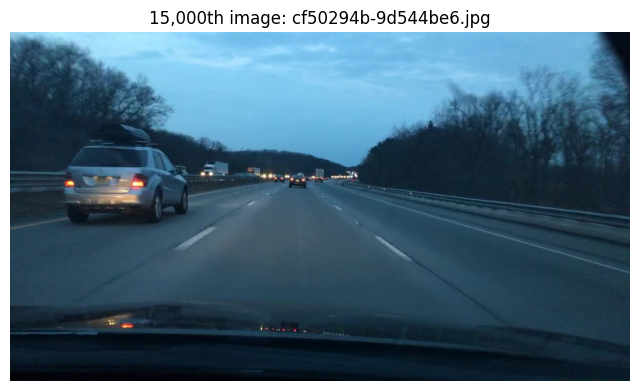

In [43]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Path to the training images folder
train_dir = "data/bdd100k/images/test"

# Get sorted list of image files
image_files = sorted(os.listdir(train_dir))

# Index of the 15,000th image (Python is 0-based, so index = 14999)
idx = 1900
img_path = os.path.join(train_dir, image_files[idx])

# Load and show image
img = Image.open(img_path)
print(np.mean(img))

plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis("off")
plt.title(f"15,000th image: {image_files[idx]}")
plt.show()


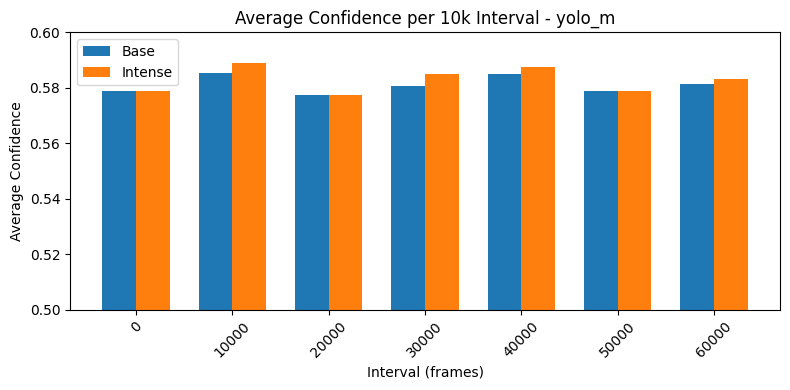

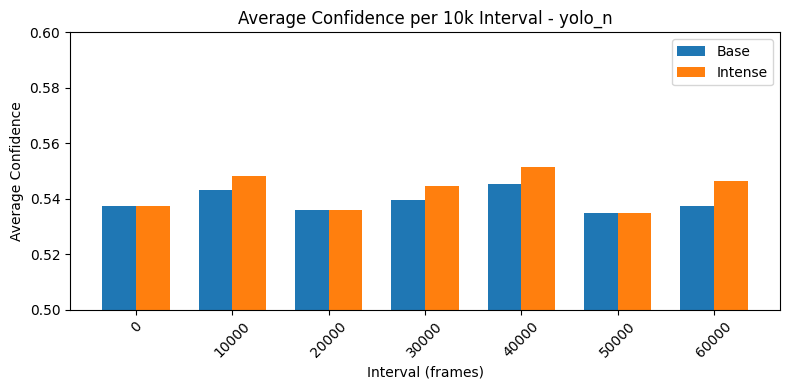

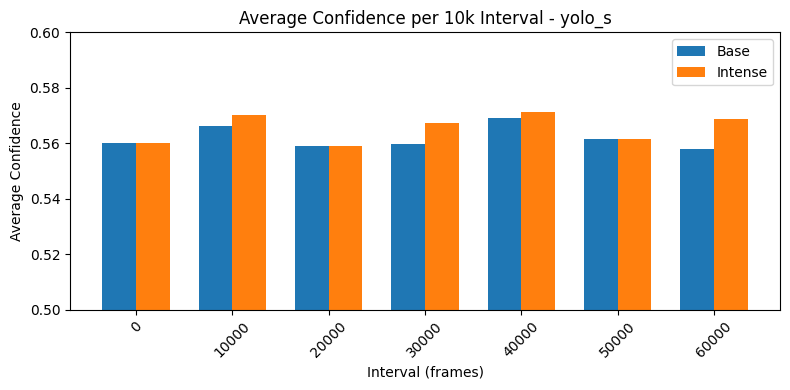

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

def process_csv(path):
    df = pd.read_csv(path)
    block_size = 20
    results = []
    for model, group in df.groupby("model"):
        group = group.reset_index(drop=True)
        group["interval"] = (group.index // block_size) * 10000
        avg_conf_by_interval = group.groupby("interval")["avg_conf"].mean().reset_index()
        avg_conf_by_interval["model"] = model
        results.append(avg_conf_by_interval)
    return pd.concat(results, ignore_index=True)

# Process both files
df_base = process_csv("knowledge/avg_conf_time_energy_by_block.csv")
df_intense = process_csv("knowledge/avg_conf_time_energy_by_block_intense.csv")

# Merge on model + interval
merged = df_base.merge(
    df_intense,
    on=["model", "interval"],
    suffixes=("_base", "_intense")
)

# Plot side-by-side bars
models = merged["model"].unique()

for model in models:
    subset = merged[merged["model"] == model]
    
    x = range(len(subset))
    width = 0.35
    
    plt.figure(figsize=(8,4))
    plt.bar([i - width/2 for i in x], subset["avg_conf_base"], width=width, label="Base")
    plt.bar([i + width/2 for i in x], subset["avg_conf_intense"], width=width, label="Intense")
    
    plt.title(f"Average Confidence per 10k Interval - {model}")
    plt.ylim(0.5, 0.6)
    plt.xlabel("Interval (frames)")
    plt.ylabel("Average Confidence")
    plt.xticks(x, subset["interval"].astype(str), rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


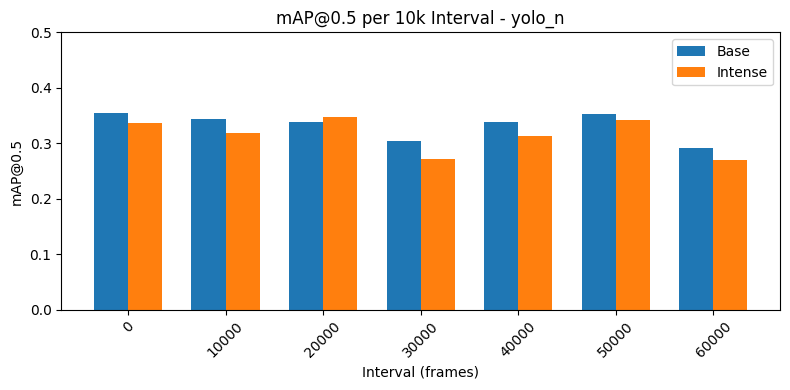

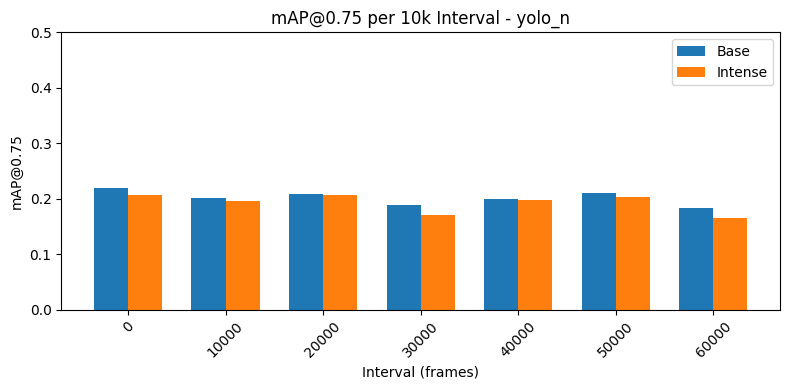

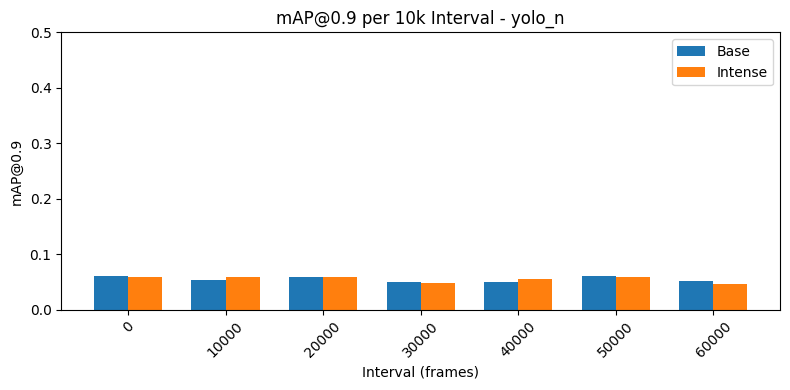

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

def process_csv_iou(path, metric="mAP@0.5", block_size=20):
    df = pd.read_csv(path)
    results = []
    for model, group in df.groupby("model"):
        group = group.reset_index(drop=True)
        group["interval"] = (group.index // block_size) * 10000
        avg_metric_by_interval = group.groupby("interval")[metric].mean().reset_index()
        avg_metric_by_interval["model"] = model
        results.append(avg_metric_by_interval)
    return pd.concat(results, ignore_index=True)

def plot_iou_comparison(base_path, intense_path, metric="mAP@0.5", ylim=(0,1)):
    df_base = process_csv_iou(base_path, metric)
    df_intense = process_csv_iou(intense_path, metric)

    merged = df_base.merge(
        df_intense,
        on=["model", "interval"],
        suffixes=("_base", "_intense")
    )

    models = merged["model"].unique()

    for model in models:
        subset = merged[merged["model"] == model]
        
        x = range(len(subset))
        width = 0.35
        
        plt.figure(figsize=(8,4))
        plt.bar([i - width/2 for i in x], subset[f"{metric}_base"], width=width, label="Base")
        plt.bar([i + width/2 for i in x], subset[f"{metric}_intense"], width=width, label="Intense")
        
        plt.title(f"{metric} per 10k Interval - {model}")
        plt.ylim(*ylim)
        plt.xlabel("Interval (frames)")
        plt.ylabel(metric)
        plt.xticks(x, subset["interval"].astype(str), rotation=45)
        plt.ylim(0, 0.5)

        plt.legend()
        plt.tight_layout()
        plt.show()

# Example usage for different IoU thresholds
# plot_iou_comparison("pilot-map-untrained/avg_conf_time_energy_acc_by_block_intense.csv",
#                     "pilot-map-trained-dark/avg_conf_time_energy_acc_by_block.csv",
#                     metric="mAP@0.5", ylim=(0,1))

# plot_iou_comparison("pilot-map-untrained/avg_conf_time_energy_acc_by_block_intense.csv",
#                     "pilot-map-trained-dark/avg_conf_time_energy_acc_by_block.csv",
#                     metric="mAP@0.75", ylim=(0,1))

# plot_iou_comparison("pilot-map-untrained/avg_conf_time_energy_acc_by_block_intense.csv",
#                     "pilot-map-trained-dark/avg_conf_time_energy_acc_by_block.csv",
#                     metric="mAP@0.9", ylim=(0,1))

# """-------------------HOW DOES CLEAR AND DARK MODELS PERFORM ON CLEAR AND DARK SECTIONS-------------------------------------------------------------------"""
# plot_iou_comparison("pilot-map-trained-dark-n/avg_conf_time_energy_acc_by_block.csv",
#                     "pilot-map-trained-clear-n/avg_conf_time_energy_acc_by_block.csv",
#                     metric="mAP@0.5", ylim=(0,1))

# plot_iou_comparison("pilot-map-trained-dark-n/avg_conf_time_energy_acc_by_block.csv",
#                     "pilot-map-trained-clear-n/avg_conf_time_energy_acc_by_block.csv",
#                     metric="mAP@0.75", ylim=(0,1))

# plot_iou_comparison("pilot-map-trained-dark-n/avg_conf_time_energy_acc_by_block.csv",
#                     "pilot-map-trained-clear-n/avg_conf_time_energy_acc_by_block.csv",
#                     metric="mAP@0.9", ylim=(0,1))
# """--------------------------------------------------------------------------------------"""
# """-------------------------DOES M DO BETTER THAN N [TRUE MODELS-------------------------------------------------------------"""
# plot_iou_comparison("pilot-map-untrained-m/avg_conf_time_energy_acc_by_block.csv",
#                     "pilot-map-untrained-n/avg_conf_time_energy_acc_by_block_intense.csv",
#                     metric="mAP@0.5", ylim=(0,1))

# plot_iou_comparison("pilot-map-untrained-m/avg_conf_time_energy_acc_by_block.csv",
#                     "pilot-map-untrained-n/avg_conf_time_energy_acc_by_block_intense.csv",
#                     metric="mAP@0.75", ylim=(0,1))

# plot_iou_comparison("pilot-map-untrained-m/avg_conf_time_energy_acc_by_block.csv",
#                     "pilot-map-untrained-n/avg_conf_time_energy_acc_by_block_intense.csv",
#                     metric="mAP@0.9", ylim=(0,1))

# """-------------------------DOES S DO BETTER THAN N [CLEAR]-------------------------------------------------------------"""
plot_iou_comparison("pilot/avg_conf_time_energy_acc_by_block.csv",
                    "pilot-map-trained-clear-n/avg_conf_time_energy_acc_by_block.csv",
                    metric="mAP@0.5", ylim=(0,1))

plot_iou_comparison("pilot/avg_conf_time_energy_acc_by_block.csv",
                    "pilot-map-trained-clear-n/avg_conf_time_energy_acc_by_block.csv",
                    metric="mAP@0.75", ylim=(0,1))

plot_iou_comparison("pilot/avg_conf_time_energy_acc_by_block.csv",
                    "pilot-map-trained-clear-n/avg_conf_time_energy_acc_by_block.csv",
                    metric="mAP@0.9", ylim=(0,1))


=== Image: 8e04a57c-b3460480 (1280x720) ===
GT   cls=2 x=0.678 y=0.534 w=0.143 h=0.193 -> px=(776.2,315.3,182.9,138.7)
GT   cls=2 x=0.598 y=0.503 w=0.078 h=0.115 -> px=(715.1,320.9,100.2,82.7)
GT   cls=2 x=0.943 y=0.689 w=0.114 h=0.508 -> px=(1134.7,313.2,145.3,365.5)
GT   cls=2 x=0.106 y=0.565 w=0.087 h=0.110 -> px=(80.0,367.4,111.8,79.1)
GT   cls=2 x=0.785 y=0.607 w=0.230 h=0.278 -> px=(857.0,336.8,294.5,200.2)
GT   cls=2 x=0.553 y=0.485 w=0.063 h=0.081 -> px=(667.7,320.0,80.4,58.4)
GT   cls=2 x=0.204 y=0.524 w=0.071 h=0.089 -> px=(215.6,345.4,91.1,64.1)
GT   cls=2 x=0.257 y=0.514 w=0.036 h=0.056 -> px=(306.1,350.2,46.2,40.4)
GT   cls=2 x=0.563 y=0.491 w=0.047 h=0.092 -> px=(690.6,320.2,59.8,66.6)
GT   cls=2 x=0.383 y=0.465 w=0.025 h=0.036 -> px=(474.9,321.8,31.8,25.7)
GT   cls=2 x=0.053 y=0.578 w=0.085 h=0.110 -> px=(13.1,376.8,109.1,79.0)
GT   cls=2 x=0.020 y=0.600 w=0.040 h=0.142 -> px=(0.1,380.9,50.6,102.4)
GT   cls=2 x=0.245 y=0.515 w=0.056 h=0.062 -> px=(277.7,348.5,72.0,45.0)

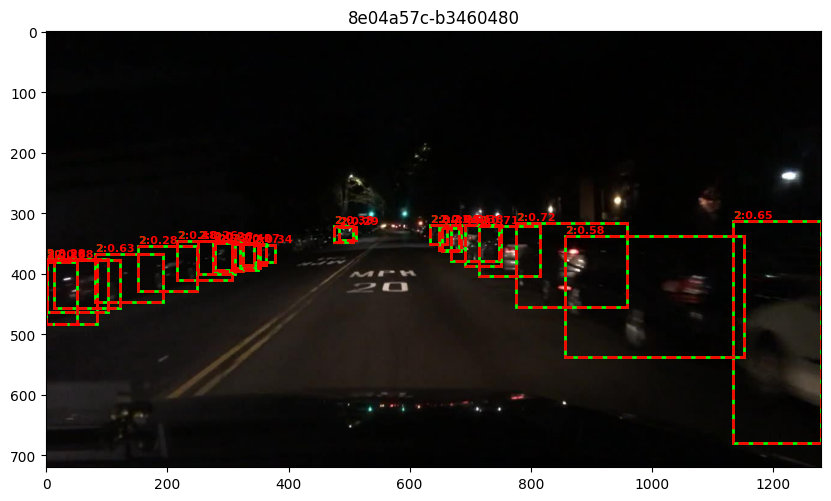


=== Image: 85d654e6-6d6ab47a (1280x720) ===
GT   cls=2 x=0.864 y=0.607 w=0.271 h=0.337 -> px=(931.9,315.8,347.5,242.8)
GT   cls=2 x=0.574 y=0.503 w=0.144 h=0.170 -> px=(642.7,300.6,183.7,122.6)
GT   cls=2 x=0.123 y=0.524 w=0.095 h=0.099 -> px=(97.1,341.5,121.6,71.4)
GT   cls=2 x=0.288 y=0.491 w=0.138 h=0.211 -> px=(280.5,277.4,176.5,151.9)
GT   cls=2 x=0.040 y=0.541 w=0.080 h=0.125 -> px=(0.0,344.4,101.8,90.3)
GT   cls=2 x=0.375 y=0.500 w=0.050 h=0.081 -> px=(448.7,330.5,63.9,58.6)
GT   cls=2 x=0.153 y=0.514 w=0.040 h=0.078 -> px=(169.6,342.1,51.4,56.1)
GT   cls=2 x=0.402 y=0.472 w=0.026 h=0.053 -> px=(498.3,321.1,33.4,37.8)
PRED cls=2 conf=0.91 x=0.864 y=0.607 w=0.271 h=0.337 -> px=(931.9,315.8,347.5,242.8)
PRED cls=2 conf=0.87 x=0.574 y=0.503 w=0.144 h=0.170 -> px=(642.7,300.6,183.7,122.6)
PRED cls=2 conf=0.69 x=0.123 y=0.524 w=0.095 h=0.099 -> px=(97.1,341.5,121.6,71.4)
PRED cls=2 conf=0.68 x=0.288 y=0.491 w=0.138 h=0.211 -> px=(280.5,277.4,176.5,151.9)
PRED cls=2 conf=0.36 x=0.040

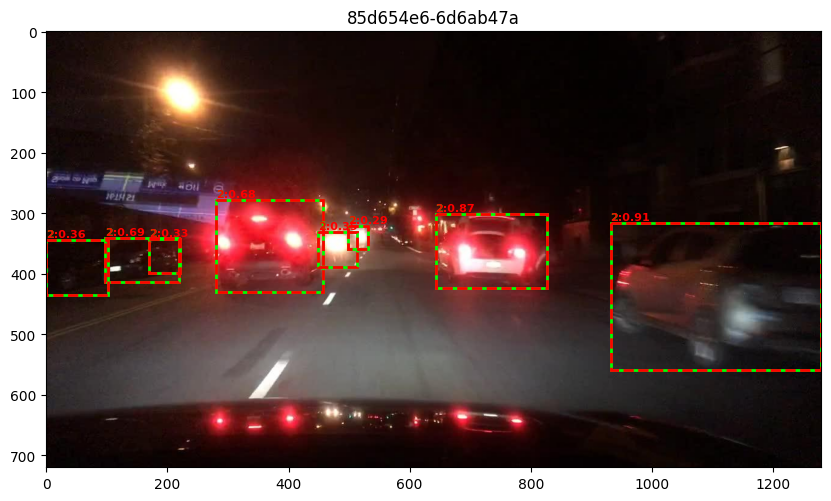


=== Image: 637f0094-1de872d0 (1280x720) ===
GT   cls=2 x=0.241 y=0.449 w=0.217 h=0.238 -> px=(169.7,237.4,277.4,171.5)
GT   cls=2 x=0.479 y=0.390 w=0.191 h=0.337 -> px=(491.1,159.9,244.4,242.4)
GT   cls=2 x=0.963 y=0.373 w=0.074 h=0.093 -> px=(1185.4,234.8,94.6,67.2)
GT   cls=2 x=0.071 y=0.486 w=0.142 h=0.232 -> px=(-0.0,266.5,181.4,166.9)
GT   cls=2 x=0.373 y=0.401 w=0.032 h=0.083 -> px=(457.1,258.5,40.4,60.0)
GT   cls=2 x=0.127 y=0.398 w=0.048 h=0.066 -> px=(132.1,263.2,62.0,47.4)
GT   cls=2 x=0.630 y=0.358 w=0.028 h=0.030 -> px=(789.1,246.9,35.3,21.4)
GT   cls=2 x=0.124 y=0.402 w=0.042 h=0.051 -> px=(131.9,271.5,53.5,36.6)
GT   cls=5 x=0.748 y=0.341 w=0.060 h=0.094 -> px=(918.5,211.5,77.2,68.0)
PRED cls=2 conf=0.92 x=0.241 y=0.449 w=0.217 h=0.238 -> px=(169.7,237.4,277.4,171.5)
PRED cls=2 conf=0.91 x=0.479 y=0.390 w=0.191 h=0.337 -> px=(491.1,159.9,244.4,242.4)
PRED cls=2 conf=0.84 x=0.963 y=0.373 w=0.074 h=0.093 -> px=(1185.4,234.8,94.6,67.2)
PRED cls=2 conf=0.84 x=0.071 y=0.486 w

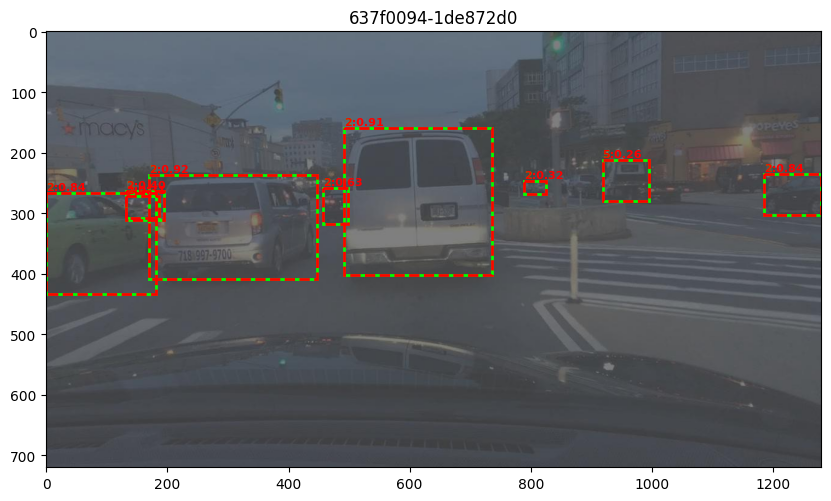


=== Image: 5ed91ca0-55bfe77a (1280x720) ===
GT   cls=2 x=0.226 y=0.473 w=0.146 h=0.183 -> px=(196.0,274.3,186.3,132.0)
GT   cls=2 x=0.437 y=0.536 w=0.432 h=0.387 -> px=(282.6,246.2,552.3,279.0)
GT   cls=0 x=0.830 y=0.455 w=0.041 h=0.199 -> px=(1035.8,256.3,52.8,143.2)
GT   cls=0 x=0.015 y=0.456 w=0.031 h=0.162 -> px=(0.0,270.1,39.6,116.5)
GT   cls=7 x=0.902 y=0.064 w=0.054 h=0.122 -> px=(1120.0,2.1,69.2,87.7)
GT   cls=0 x=0.146 y=0.446 w=0.023 h=0.112 -> px=(172.2,280.8,28.9,80.5)
GT   cls=0 x=0.123 y=0.437 w=0.018 h=0.081 -> px=(145.3,285.3,23.3,58.2)
GT   cls=0 x=0.096 y=0.449 w=0.025 h=0.122 -> px=(106.2,279.2,32.3,87.8)
PRED cls=2 conf=0.92 x=0.226 y=0.473 w=0.146 h=0.183 -> px=(196.0,274.3,186.3,132.0)
PRED cls=2 conf=0.89 x=0.437 y=0.536 w=0.432 h=0.387 -> px=(282.6,246.2,552.3,279.0)
PRED cls=0 conf=0.79 x=0.830 y=0.455 w=0.041 h=0.199 -> px=(1035.8,256.3,52.8,143.2)
PRED cls=0 conf=0.70 x=0.015 y=0.456 w=0.031 h=0.162 -> px=(0.0,270.1,39.6,116.5)
PRED cls=7 conf=0.67 x=0.902 y

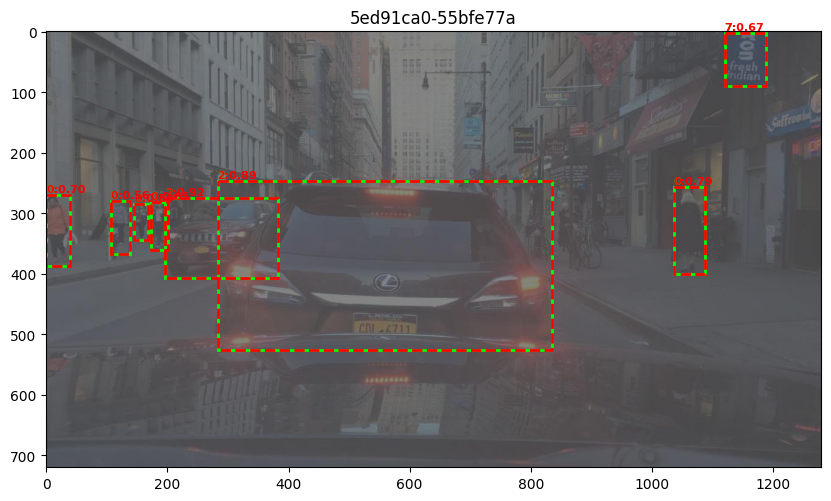


=== Image: 38a8a37d-c41cc42d (1280x720) ===
GT   cls=2 x=0.366 y=0.415 w=0.139 h=0.220 -> px=(379.6,219.8,177.5,158.6)
GT   cls=2 x=0.502 y=0.379 w=0.047 h=0.057 -> px=(613.1,252.3,59.8,40.7)
GT   cls=2 x=0.569 y=0.378 w=0.105 h=0.127 -> px=(661.5,226.8,134.2,91.1)
GT   cls=2 x=0.477 y=0.362 w=0.031 h=0.048 -> px=(590.1,243.1,39.9,34.9)
GT   cls=2 x=0.481 y=0.361 w=0.037 h=0.059 -> px=(592.0,239.2,47.6,42.2)
GT   cls=2 x=0.472 y=0.367 w=0.021 h=0.044 -> px=(590.7,248.6,27.3,31.5)
PRED cls=2 conf=0.89 x=0.366 y=0.415 w=0.139 h=0.220 -> px=(379.6,219.8,177.5,158.6)
PRED cls=2 conf=0.53 x=0.502 y=0.379 w=0.047 h=0.057 -> px=(613.1,252.3,59.8,40.7)
PRED cls=2 conf=0.35 x=0.569 y=0.378 w=0.105 h=0.127 -> px=(661.5,226.8,134.2,91.1)
PRED cls=2 conf=0.32 x=0.477 y=0.362 w=0.031 h=0.048 -> px=(590.1,243.1,39.9,34.9)
PRED cls=2 conf=0.26 x=0.481 y=0.361 w=0.037 h=0.059 -> px=(592.0,239.2,47.6,42.2)
PRED cls=2 conf=0.26 x=0.472 y=0.367 w=0.021 h=0.044 -> px=(590.7,248.6,27.3,31.5)


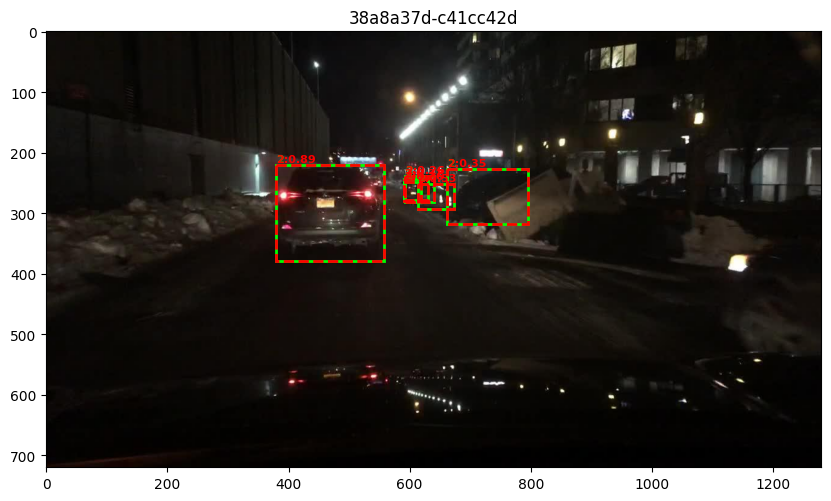

In [11]:
import os
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Paths
img_dir = "data/bdd100k/images/train"  # adjust if different
label_dir = "runs_artifact/knowledge_20250904_211712_n_1/inferences"
pred_dir = "runs_artifact/knowledge_20250904_190553_n_retrain_1/inferences"

n = 5  # number of samples to visualize

# ------------------------------------------------------------
# Helper functions
# ------------------------------------------------------------
def load_labels(path, is_pred=False):
    data = {}
    for file in glob.glob(os.path.join(path, "*.txt")):
        name = os.path.splitext(os.path.basename(file))[0]
        items = []
        with open(file, "r") as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue
                if is_pred:
                    cls, x, y, w, h, conf = parts
                    items.append((int(cls), float(x), float(y), float(w), float(h), float(conf)))
                else:
                    cls, x, y, w, h = parts
                    items.append((int(cls), float(x), float(y), float(w), float(h), 1.0))
        data[name] = items
    return data


def denorm_bbox(bbox, img_w, img_h):
    _, x, y, w, h, _ = bbox
    x1 = (x - w / 2) * img_w
    y1 = (y - h / 2) * img_h
    bw = w * img_w
    bh = h * img_h
    return x1, y1, bw, bh

# ------------------------------------------------------------
# Load data
# ------------------------------------------------------------
gt = load_labels(label_dir, is_pred=True)
preds = load_labels(pred_dir, is_pred=True)

all_ids = list(gt.keys())
sample_ids = random.sample(all_ids, min(n, len(all_ids)))

# ------------------------------------------------------------
# Plot with debug prints
# ------------------------------------------------------------
for img_id in sample_ids:
    img_path = os.path.join(img_dir, f"{img_id}.jpg")
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        continue

    img = plt.imread(img_path)
    h, w = img.shape[:2]

    print("\n=== Image:", img_id, f"({w}x{h}) ===")

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.imshow(img)
    ax.set_title(f"{img_id}")

    # GT boxes (green)
    for bbox in gt.get(img_id, []):
        x1, y1, bw, bh = denorm_bbox(bbox, w, h)
        print(f"GT   cls={bbox[0]} x={bbox[1]:.3f} y={bbox[2]:.3f} w={bbox[3]:.3f} h={bbox[4]:.3f} -> px=({x1:.1f},{y1:.1f},{bw:.1f},{bh:.1f})")
        rect = patches.Rectangle((x1, y1), bw, bh, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, str(bbox[0]), color='lime', fontsize=8, weight='bold')

    # Pred boxes (red)
    for bbox in preds.get(img_id, []):
        x1, y1, bw, bh = denorm_bbox(bbox, w, h)
        print(f"PRED cls={bbox[0]} conf={bbox[5]:.2f} x={bbox[1]:.3f} y={bbox[2]:.3f} w={bbox[3]:.3f} h={bbox[4]:.3f} -> px=({x1:.1f},{y1:.1f},{bw:.1f},{bh:.1f})")
        rect = patches.Rectangle((x1, y1), bw, bh, linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"{bbox[0]}:{bbox[5]:.2f}", color='red', fontsize=8, weight='bold')

    plt.show()

In [12]:
#!/usr/bin/env python3
"""
induce_drift.py

Applies artificial drift to BDD100K train images by splitting
the dataset into 7 parts of RANDOMIZED sizes that are guaranteed
to sum to a TARGET_SUM (70,000). It applies:
1. clear (no change)
2. dark (brightness reduced)
3. clear
4. fog (contrast reduced)
5. dark
6. clear
7. fog

The use of a fixed random seed ensures the randomized intervals are
reproducible for experimental consistency.

Output is saved in data/bdd100k/images/train
"""

import os
import random
import shutil
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision.transforms.functional import adjust_brightness, adjust_contrast

TOTAL_PARTS = 7
TARGET_SUM = 70000 
RANDOM_SEED = 1 

# Part size will be randomized within this range
MIN_PART_SIZE = 8000
MAX_PART_SIZE = 12000
PART_SIZE_STEP = 500


# =======================
# UTILS
# =======================
def load_image_paths(folder):
    """Loads and sorts all image paths from a directory."""
    exts = (".jpg", ".jpeg", ".png")
    files = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(exts)]
    files.sort()
    return files

def generate_constrained_partitions(num_parts, total_sum, min_val, max_val, step):
    """
    Generates a list of random integers that sum to a target value,
    with each integer respecting min/max/step constraints.
    """
    random.seed(RANDOM_SEED)
    partitions = []
    remaining_sum = total_sum

    for i in range(num_parts - 1):
        parts_left_to_generate = num_parts - (i + 1)
        
        # Calculate dynamic bounds for the current part
        # Lower bound: Must be at least min_val, and leave enough for remaining parts to be max_val
        lower_bound = max(min_val, remaining_sum - (parts_left_to_generate * max_val))
        
        # Upper bound: Must be at most max_val, and leave enough for remaining parts to be min_val
        upper_bound = min(max_val, remaining_sum - (parts_left_to_generate * min_val))

        # Align bounds to the nearest step
        lower_bound = int(np.ceil(lower_bound / step) * step)
        upper_bound = int(np.floor(upper_bound / step) * step)

        if lower_bound > upper_bound:
            raise ValueError("Cannot create a valid partition with the given constraints.")

        part_size = random.randrange(lower_bound, upper_bound + 1, step)
        
        partitions.append(part_size)
        remaining_sum -= part_size

    partitions.append(remaining_sum) # The last part is what's left
    return partitions

# =======================
# MAIN
# =======================
def main():
    # --- NEW: Generate random sizes that are guaranteed to sum to TARGET_SUM ---
    try:
        part_sizes = generate_constrained_partitions(
            TOTAL_PARTS, TARGET_SUM, MIN_PART_SIZE, MAX_PART_SIZE, PART_SIZE_STEP
        )
        # Verification check
        assert sum(part_sizes) == TARGET_SUM
        print(f"Generated constrained random part sizes (reproducible): {part_sizes}")
    except ValueError as e:
        print(f"Error: {e}. Could not generate valid partitions. Check constraints.")
        return


if __name__ == "__main__":
    main()

Generated constrained random part sizes (reproducible): [9000, 8500, 10000, 8500, 11500, 12000, 10500]


In [13]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm

# =======================
# CONFIGURATION
# =======================
# Directory with the full 70k augmented images
AUGMENTED_TRAIN_DIR = Path("data/bdd100k/images/train")
# Directory with the clean test images for reference
REF_IMAGE_DIR = Path("data/bdd100k/images/test")

# The reproducible random part sizes you generated
PART_SIZES = [9000, 8500, 10000, 8500, 11500, 12000, 10500]
# The sequence of drift applied to each part
DRIFT_SEQUENCE = ["clear", "dark", "clear", "fog", "dark", "clear", "fog"]

# The window size for analysis (should match retrain.py)
ANALYSIS_WINDOW_SIZE = 1000
# The delay after the boundary to perform the check
OFFSET_DELAY = 100

# =======================
# CORE LOGIC (from retrain.py)
# =======================

def luminance_histogram(img_path, bins=64):
    """Computes the luminance histogram for a single image."""
    try:
        with Image.open(img_path).convert("RGB") as im:
            arr = np.asarray(im, dtype=np.float32)
            y = 0.299 * arr[..., 0] + 0.587 * arr[..., 1] + 0.114 * arr[..., 2]
            y = np.clip(y, 0, 255)
            hist, _ = np.histogram(y, bins=bins, range=(0, 255), density=False)
            hist = hist.astype(np.float64)
            hist += 1e-12  # Additive smoothing
            return hist / hist.sum()
    except Exception:
        return None

def get_distribution_stats(hist):
    """Calculates mean and std dev from a luminance histogram."""
    if hist is None:
        return 0, 0
    centers = np.linspace(0, 255, len(hist), endpoint=False) + (255 / len(hist)) / 2
    mean = np.sum(hist * centers)
    var = np.sum(hist * (centers - mean)**2)
    return mean, np.sqrt(max(var, 1e-9))

def deduce_drift_type(ref_hist, current_hist):
    """Deduces drift type by comparing luminance statistics."""
    ref_mean, ref_std = get_distribution_stats(ref_hist)
    cur_mean, cur_std = get_distribution_stats(current_hist)

    print(f"  - Reference Stats : Mean={ref_mean:.2f}, Std Dev={ref_std:.2f}")
    print(f"  - Current Stats   : Mean={cur_mean:.2f}, Std Dev={cur_std:.2f}")

    # Heuristic: If mean luminance drops significantly, it's dark.
    if cur_mean < ref_mean * 0.75:
        result = "dark"
    # Heuristic: If std dev (contrast) drops significantly, it's fog.
    elif cur_std < ref_std * 0.75:
        result = "fog"
    else:
        result = "clear"
    
    print(f"  - Classification  : Detected '{result}' drift.")
    return result

def get_avg_histogram_for_window(image_paths):
    """Calculates the average histogram for a list of image paths."""
    hists = [h for p in tqdm(image_paths, desc="Analyzing window", leave=False) if (h := luminance_histogram(p)) is not None]
    if not hists:
        return None
    return np.mean(np.array(hists), axis=0)

# =======================
# MAIN SCRIPT
# =======================

def main():
    print("--- Drift Detection Boundary Check ---")

    # 1. Load all image paths
    print(f"\nLoading image paths from {AUGMENTED_TRAIN_DIR}...")
    all_train_images = sorted([p for p in AUGMENTED_TRAIN_DIR.glob("*.jpg")])
    print(f"Found {len(all_train_images)} images.")

    # 2. Calculate the reference distribution from the clean test set
    print(f"\nCalculating reference distribution from first {ANALYSIS_WINDOW_SIZE} images in {REF_IMAGE_DIR}...")
    ref_image_paths = sorted([p for p in REF_IMAGE_DIR.glob("*.jpg")])[:ANALYSIS_WINDOW_SIZE]
    ref_dist = get_avg_histogram_for_window(ref_image_paths)
    if ref_dist is None:
        print("Error: Could not calculate reference distribution. Aborting.")
        return

    # 3. Calculate boundary indices
    boundaries = np.cumsum(PART_SIZES)

    # 4. Iterate through each boundary and perform the check
    for i, boundary_idx in enumerate(boundaries[:-1]): # No need to check after the last part
        check_idx = boundary_idx + OFFSET_DELAY
        start_idx = check_idx - ANALYSIS_WINDOW_SIZE
        end_idx = check_idx

        if end_idx > len(all_train_images):
            print(f"\nSkipping boundary at {boundary_idx} as it's too close to the end of the dataset.")
            continue

        from_drift = DRIFT_SEQUENCE[i]
        to_drift = DRIFT_SEQUENCE[i+1]
        
        print("\n" + "="*50)
        print(f"Checking Boundary {i+1}: '{from_drift}' -> '{to_drift}'")
        print(f"Boundary Index: {boundary_idx}, Check Index: {check_idx}")
        print(f"Analyzing window of {ANALYSIS_WINDOW_SIZE} images from index {start_idx} to {end_idx-1}")
        
        # Get the average histogram for the current window
        window_paths = all_train_images[start_idx:end_idx]
        current_dist = get_avg_histogram_for_window(window_paths)
        
        if current_dist is None:
            print("  - Could not analyze this window.")
            continue
            
        # Deduce the drift type and print metrics
        deduce_drift_type(ref_dist, current_dist)
        print("="*50)

if __name__ == "__main__":
    main()

--- Drift Detection Boundary Check ---

Loading image paths from data/bdd100k/images/train...
Found 70000 images.

Calculating reference distribution from first 1000 images in data/bdd100k/images/test...



Checking Boundary 1: 'clear' -> 'dark'
Boundary Index: 9000, Check Index: 9100
Analyzing window of 1000 images from index 8100 to 9099


  - Reference Stats : Mean=75.49, Std Dev=65.68
  - Current Stats   : Mean=69.17, Std Dev=64.72
  - Classification  : Detected 'clear' drift.

Checking Boundary 2: 'dark' -> 'clear'
Boundary Index: 17500, Check Index: 17600
Analyzing window of 1000 images from index 16600 to 17599


  - Reference Stats : Mean=75.49, Std Dev=65.68
  - Current Stats   : Mean=29.28, Std Dev=33.09
  - Classification  : Detected 'dark' drift.

Checking Boundary 3: 'clear' -> 'fog'
Boundary Index: 27500, Check Index: 27600
Analyzing window of 1000 images from index 26600 to 27599


  - Reference Stats : Mean=75.49, Std Dev=65.68
  - Current Stats   : Mean=73.25, Std Dev=63.91
  - Classification  : Detected 'clear' drift.

Checking Boundary 4: 'fog' -> 'dark'
Boundary Index: 36000, Check Index: 36100
Analyzing window of 1000 images from index 35100 to 36099


  - Reference Stats : Mean=75.49, Std Dev=65.68
  - Current Stats   : Mean=67.03, Std Dev=42.51
  - Classification  : Detected 'fog' drift.

Checking Boundary 5: 'dark' -> 'clear'
Boundary Index: 47500, Check Index: 47600
Analyzing window of 1000 images from index 46600 to 47599


  - Reference Stats : Mean=75.49, Std Dev=65.68
  - Current Stats   : Mean=29.64, Std Dev=32.09
  - Classification  : Detected 'dark' drift.

Checking Boundary 6: 'clear' -> 'fog'
Boundary Index: 59500, Check Index: 59600
Analyzing window of 1000 images from index 58600 to 59599


  - Reference Stats : Mean=75.49, Std Dev=65.68
  - Current Stats   : Mean=76.88, Std Dev=64.92
  - Classification  : Detected 'clear' drift.


In [14]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from scipy.stats import entropy

# =======================
# CONFIGURATION
# =======================
# --- Paths ---
AUGMENTED_TRAIN_DIR = Path("data/bdd100k/images/train")
REF_IMAGE_DIR = Path("data/bdd100k/images/test")

# --- Drift Induction Parameters (must match induce.py) ---
PART_SIZES = [9000, 8500, 10000, 8500, 11500, 12000, 10500]
DRIFT_SEQUENCE = ["clear", "dark", "clear", "fog", "dark", "clear", "fog"]

# --- System Simulation Parameters (must match your MAPE-K loop) ---
MONITOR_WINDOW_SIZE = 1000  # The size of the 'current' and 'reference' windows in monitor_drift
DRIFT_CHECK_INTERVAL = 500 # How often the system checks for drift (from run_execute_drift)
DRIFT_THRESHOLD = 0.07     # The KL divergence value that triggers an alert (from analyse_drift)
RETRAIN_WINDOW_SIZE = 1000 # The size of the window used for classification (from retrain.py)

# =======================
# CORE LOGIC (from your codebase)
# =======================

def luminance_histogram(img_path, bins=64):
    """Computes the luminance histogram for a single image."""
    try:
        with Image.open(img_path).convert("RGB") as im:
            arr = np.asarray(im, dtype=np.float32)
            y = 0.299 * arr[..., 0] + 0.587 * arr[..., 1] + 0.114 * arr[..., 2]
            y = np.clip(y, 0, 255)
            hist, _ = np.histogram(y, bins=bins, range=(0, 255), density=False)
            hist = hist.astype(np.float64)
            hist += 1e-12
            return hist / hist.sum()
    except Exception:
        return None

def kl_divergence(p, q):
    """Calculates KL(p || q)."""
    p = np.asarray(p) + 1e-12
    q = np.asarray(q) + 1e-12
    return entropy(p, q)

def get_distribution_stats(hist):
    """Calculates mean and std dev from a luminance histogram."""
    if hist is None: return 0, 0
    centers = np.linspace(0, 255, len(hist), endpoint=False) + (255 / len(hist)) / 2
    mean = np.sum(hist * centers)
    var = np.sum(hist * (centers - mean)**2)
    return mean, np.sqrt(max(var, 1e-9))

def deduce_drift_type(stable_ref_hist, current_hist):
    """Deduces drift type by comparing current data to a stable reference."""
    ref_mean, ref_std = get_distribution_stats(stable_ref_hist)
    cur_mean, cur_std = get_distribution_stats(current_hist)

    print(f"    - Stable Ref Stats: Mean={ref_mean:.2f}, Std Dev={ref_std:.2f}")
    print(f"    - Drifted Stats   : Mean={cur_mean:.2f}, Std Dev={cur_std:.2f}")

    if cur_mean < ref_mean * 0.75:
        result = "dark"
    elif cur_std < ref_std * 0.75:
        result = "fog"
    else:
        result = "clear"
    
    print(f"    -> Classification: The system will classify this drift as '{result}'.")
    return result

# =======================
# MAIN SIMULATION SCRIPT
# =======================

def main():
    print("--- Drift Detection and Classification Simulator ---")

    # 1. Load image paths and pre-calculate all histograms for efficiency
    print(f"\nStep 1: Pre-calculating histograms for all {sum(PART_SIZES)} images...")
    all_train_images = sorted([p for p in AUGMENTED_TRAIN_DIR.glob("*.jpg")])[:sum(PART_SIZES)]
    all_hists = [h for p in tqdm(all_train_images, desc="Caching histograms") if (h := luminance_histogram(p)) is not None]

    # 2. Calculate the stable reference distribution used by retrain.py
    print(f"\nStep 2: Calculating stable reference distribution from {REF_IMAGE_DIR}...")
    ref_image_paths = sorted([p for p in REF_IMAGE_DIR.glob("*.jpg")])[:RETRAIN_WINDOW_SIZE]
    stable_ref_dist = np.mean([h for p in ref_image_paths if (h := luminance_histogram(p)) is not None], axis=0)

    # 3. Simulate the monitoring loop
    print("\nStep 3: Simulating the drift monitoring process...")
    boundaries = np.cumsum(PART_SIZES)
    current_boundary_idx = 0
    drift_detected_in_segment = False

    start_monitor_idx = MONITOR_WINDOW_SIZE * 2
    for i in range(start_monitor_idx, len(all_hists), DRIFT_CHECK_INTERVAL):
        # Check if we have crossed into a new drift segment
        if i > boundaries[current_boundary_idx]:
            if not drift_detected_in_segment:
                print("\n" + "="*60)
                print(f"Boundary Passed: '{DRIFT_SEQUENCE[current_boundary_idx]}' -> '{DRIFT_SEQUENCE[current_boundary_idx+1]}'")
                print(f"NOTE: No drift was detected in the window immediately following this boundary.")
                print("="*60)
            current_boundary_idx += 1
            drift_detected_in_segment = False
        
        if drift_detected_in_segment:
            continue

        # Define windows for monitor_drift
        monitor_ref_window = all_hists[i - MONITOR_WINDOW_SIZE*2 : i - MONITOR_WINDOW_SIZE]
        monitor_cur_window = all_hists[i - MONITOR_WINDOW_SIZE : i]
        
        if not monitor_ref_window or not monitor_cur_window:
            continue

        # Calculate KL divergence as done in monitor_drift
        monitor_ref_dist = np.mean(np.array(monitor_ref_window), axis=0)
        monitor_cur_dist = np.mean(np.array(monitor_cur_window), axis=0)
        kl = kl_divergence(monitor_cur_dist, monitor_ref_dist)

        # Check if drift is detected
        if kl > DRIFT_THRESHOLD:
            drift_detected_in_segment = True
            from_drift = DRIFT_SEQUENCE[current_boundary_idx]
            to_drift = DRIFT_SEQUENCE[current_boundary_idx+1]

            print("\n" + "="*60)
            print(f"DRIFT DETECTED after boundary: '{from_drift}' -> '{to_drift}'")
            print(f"  - Detection Index: {i} (KL={kl:.4f} > {DRIFT_THRESHOLD})")
            print(f"  - This is {i - boundaries[current_boundary_idx-1]} images after the boundary.")
            
            # Now, simulate the classification logic from retrain.py
            print("\n  --- Running Drift Classification Logic ---")
            # The classification uses the data that triggered the alert
            classification_window = monitor_cur_window
            classification_dist = np.mean(np.array(classification_window), axis=0)
            
            deduce_drift_type(stable_ref_dist, classification_dist)
            print("="*60)

if __name__ == "__main__":
    main()

--- Drift Detection and Classification Simulator ---

Step 1: Pre-calculating histograms for all 70000 images...


Caching histograms: 100%|██████████| 70000/70000 [16:17<00:00, 71.58it/s]



Step 2: Calculating stable reference distribution from data/bdd100k/images/test...

Step 3: Simulating the drift monitoring process...

Boundary Passed: 'clear' -> 'dark'
NOTE: No drift was detected in the window immediately following this boundary.

DRIFT DETECTED after boundary: 'dark' -> 'clear'
  - Detection Index: 9500 (KL=0.0978 > 0.07)
  - This is 500 images after the boundary.

  --- Running Drift Classification Logic ---
    - Stable Ref Stats: Mean=75.49, Std Dev=65.68
    - Drifted Stats   : Mean=49.90, Std Dev=54.38
    -> Classification: The system will classify this drift as 'dark'.

DRIFT DETECTED after boundary: 'clear' -> 'fog'
  - Detection Index: 18000 (KL=2.7957 > 0.07)
  - This is 500 images after the boundary.

  --- Running Drift Classification Logic ---
    - Stable Ref Stats: Mean=75.49, Std Dev=65.68
    - Drifted Stats   : Mean=48.19, Std Dev=54.05
    -> Classification: The system will classify this drift as 'dark'.

DRIFT DETECTED after boundary: 'fog' -> 

IndexError: list index out of range

In [15]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from scipy.stats import entropy

# =======================
# CONFIGURATION
# =======================
# --- Paths ---
AUGMENTED_TRAIN_DIR = Path("data/bdd100k/images/train")
HISTOGRAM_CACHE_FILE = "precalculated_histograms.npy"

# --- System Simulation Parameters ---
MONITOR_WINDOW_SIZE = 1000
DRIFT_CHECK_INTERVAL = 500
DRIFT_THRESHOLD = 0.07

# =======================
# CORE LOGIC
# =======================

def luminance_histogram(img_path, bins=64):
    """Computes the luminance histogram for a single image."""
    try:
        with Image.open(img_path).convert("RGB") as im:
            arr = np.asarray(im, dtype=np.float32)
            y = 0.299 * arr[..., 0] + 0.587 * arr[..., 1] + 0.114 * arr[..., 2]
            y = np.clip(y, 0, 255)
            hist, _ = np.histogram(y, bins=bins, range=(0, 255), density=False)
            hist = hist.astype(np.float64)
            hist += 1e-12
            return hist / hist.sum()
    except Exception:
        return None

def kl_divergence(p, q):
    """Calculates KL(p || q)."""
    p = np.asarray(p) + 1e-12
    q = np.asarray(q) + 1e-12
    return entropy(p, q)

def get_distribution_stats(hist):
    """Calculates mean and std dev from a luminance histogram."""
    if hist is None: return 0, 0
    centers = np.linspace(0, 255, len(hist), endpoint=False) + (255 / len(hist)) / 2
    mean = np.sum(hist * centers)
    var = np.sum(hist * (centers - mean)**2)
    return mean, np.sqrt(max(var, 1e-9))

def estimate_factors(ref_hist, cur_hist):
    """Estimates brightness and contrast factors based on statistical changes."""
    ref_mean, ref_std = get_distribution_stats(ref_hist)
    cur_mean, cur_std = get_distribution_stats(cur_hist)

    if ref_mean == 0 or ref_std == 0:
        return 1.0, 1.0

    est_brightness_factor = cur_mean / ref_mean
    est_contrast_factor = cur_std / ref_std
    return est_brightness_factor, est_contrast_factor

# =======================
# MAIN SIMULATION SCRIPT
# =======================

def main():
    print("--- Pilot Test for Drift Detection and Factor Estimation ---")

    if Path(HISTOGRAM_CACHE_FILE).exists():
        print(f"\nStep 1: Loading pre-calculated histograms from {HISTOGRAM_CACHE_FILE}...")
        all_hists = np.load(HISTOGRAM_CACHE_FILE)
        print("Loading complete.")
    else:
        print(f"\nStep 1: No cache found. Pre-calculating histograms for all images in {AUGMENTED_TRAIN_DIR}...")
        all_train_images = sorted([p for p in AUGMENTED_TRAIN_DIR.glob("*.jpg")])
        if not all_train_images:
            print(f"Error: No images found in {AUGMENTED_TRAIN_DIR}. Aborting.")
            return
            
        hists_list = [h for p in tqdm(all_train_images, desc="Caching histograms") if (h := luminance_histogram(p)) is not None]
        all_hists = np.array(hists_list)
        
        print(f"\nSaving {len(all_hists)} histograms to {HISTOGRAM_CACHE_FILE} for future runs...")
        np.save(HISTOGRAM_CACHE_FILE, all_hists)
        print("Saving complete.")
    
    print(f"Successfully loaded {len(all_hists)} histograms.")

    # 2. Simulate the monitoring loop
    print(f"\nStep 2: Simulating drift check every {DRIFT_CHECK_INTERVAL} images...")
    
    start_index = MONITOR_WINDOW_SIZE * 2
    for i in range(start_index, len(all_hists), DRIFT_CHECK_INTERVAL):
        
        ref_window_hists = all_hists[i - MONITOR_WINDOW_SIZE*2 : i - MONITOR_WINDOW_SIZE]
        cur_window_hists = all_hists[i - MONITOR_WINDOW_SIZE : i]
        
        if len(ref_window_hists) == 0 or len(cur_window_hists) == 0:
            continue

        ref_dist = np.mean(ref_window_hists, axis=0)
        cur_dist = np.mean(cur_window_hists, axis=0)
        
        kl = kl_divergence(cur_dist, ref_dist)

        if kl > DRIFT_THRESHOLD:
            print("\n" + "="*60)
            print(f"DRIFT DETECTED at Image Index ~{i}")
            print(f"  - KL Divergence: {kl:.4f} (Threshold: {DRIFT_THRESHOLD})")
            print(f"  - Comparing window [{i-2000}:{i-1000}] vs [{i-1000}:{i}]")
            
            print("\n  --- Estimating Causal Factors ---")
            brightness, contrast = estimate_factors(ref_dist, cur_dist)
            print(f"  - Probable Brightness Factor: {brightness:.2f}")
            print(f"  - Probable Contrast Factor:   {contrast:.2f}")
            print("="*60)

    print("\n--- Pilot Test Complete ---")

if __name__ == "__main__":
    main()

--- Pilot Test for Drift Detection and Factor Estimation ---

Step 1: Loading pre-calculated histograms from precalculated_histograms.npy...
Loading complete.
Successfully loaded 70000 histograms.

Step 2: Simulating drift check every 500 images...

DRIFT DETECTED at Image Index ~10000
  - KL Divergence: 0.2046 (Threshold: 0.07)
  - Comparing window [8000:9000] vs [9000:10000]

  --- Estimating Causal Factors ---
  - Probable Brightness Factor: 0.71
  - Probable Contrast Factor:   0.75

DRIFT DETECTED at Image Index ~18500
  - KL Divergence: 0.2003 (Threshold: 0.07)
  - Comparing window [16500:17500] vs [17500:18500]

  --- Estimating Causal Factors ---
  - Probable Brightness Factor: 1.39
  - Probable Contrast Factor:   1.37

DRIFT DETECTED at Image Index ~28000
  - KL Divergence: 0.0705 (Threshold: 0.07)
  - Comparing window [26000:27000] vs [27000:28000]

  --- Estimating Causal Factors ---
  - Probable Brightness Factor: 0.97
  - Probable Contrast Factor:   0.84

DRIFT DETECTED at 

In [53]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from scipy.stats import entropy

# =======================
# CONFIGURATION
# =======================
# --- Paths ---
KNOWLEDGE_DIR = Path("knowledge")
AUGMENTED_TRAIN_DIR = Path("data/bdd100k/images/train") # Needed for cache creation
REF_IMAGE_DIR = Path("data/bdd100k/images/test")
HISTOGRAM_CACHE_FILE = KNOWLEDGE_DIR / "precalculated_histograms.npy"
STABLE_REF_CACHE_FILE = KNOWLEDGE_DIR / "stable_reference_dist.npy"

# --- System Simulation Parameters ---
MONITOR_WINDOW_SIZE = 1000
DRIFT_CHECK_INTERVAL = 500
DRIFT_THRESHOLD = 0.07
CLASSIFICATION_WINDOW_SIZE = 1000 # Window size for the stable reference

# =======================
# CORE LOGIC (from retrain.py and monitor.py)
# =======================

def luminance_histogram(img_path, bins=64):
    """Computes the luminance histogram for a single image."""
    try:
        with Image.open(img_path).convert("RGB") as im:
            arr = np.asarray(im, dtype=np.float32)
            y = 0.299 * arr[..., 0] + 0.587 * arr[..., 1] + 0.114 * arr[..., 2]
            y = np.clip(y, 0, 255)
            hist, _ = np.histogram(y, bins=bins, range=(0, 255), density=False)
            hist = hist.astype(np.float64)
            hist += 1e-12
            return hist / hist.sum()
    except Exception:
        return None

def kl_divergence(p, q):
    """Calculates KL(p || q)."""
    p = np.asarray(p) + 1e-12
    q = np.asarray(q) + 1e-12
    return entropy(p, q)

def get_distribution_stats(hist):
    """Calculates mean and std dev from a luminance histogram."""
    centers = np.linspace(0, 255, len(hist), endpoint=False) + (255 / len(hist)) / 2
    mean = np.sum(hist * centers)
    var = np.sum(hist * (centers - mean)**2)
    return mean, np.sqrt(max(var, 1e-9))

def deduce_drift_type(stable_ref_hist, current_hist):
    """Deduces drift type by comparing the relative change in luminance statistics."""
    ref_mean, ref_std = get_distribution_stats(stable_ref_hist)
    cur_mean, cur_std = get_distribution_stats(current_hist)

    print(f"  - Stable Ref Stats : Mean={ref_mean:.2f}, Std Dev={ref_std:.2f}")
    print(f"  - Drifted Stats    : Mean={cur_mean:.2f}, Std Dev={cur_std:.2f}")

    if ref_mean == 0 or ref_std == 0: return "clear"

    mean_change_ratio = cur_mean / ref_mean
    std_change_ratio = cur_std / ref_std
    print(f"  - Change Ratios    : Mean={mean_change_ratio:.2%}, Std Dev={std_change_ratio:.2%}")

    is_dark = mean_change_ratio < 0.80
    is_foggy = std_change_ratio < 0.85

    if not is_dark and not is_foggy:
        return "clear"
    if is_dark and not is_foggy:
        return "dark"
    if is_foggy and not is_dark:
        return "fog"
    if is_dark and is_foggy:
        return "dark"
    return "clear"

# =======================
# MAIN SIMULATION SCRIPT
# =======================

def main():
    print("--- Pilot Test for Drift Detection and Action Classification ---")
    KNOWLEDGE_DIR.mkdir(exist_ok=True)

    # --- NEW: Self-contained caching for the main histogram dataset ---
    if HISTOGRAM_CACHE_FILE.exists():
        print(f"\nStep 1: Loading pre-calculated histograms from {HISTOGRAM_CACHE_FILE}...")
        all_hists = np.load(HISTOGRAM_CACHE_FILE)
    else:
        print(f"\nStep 1: No cache found. Pre-calculating histograms from {AUGMENTED_TRAIN_DIR}...")
        all_train_images = sorted([p for p in AUGMENTED_TRAIN_DIR.glob("*.jpg")])
        if not all_train_images:
            print(f"Error: No images found in {AUGMENTED_TRAIN_DIR}. Aborting.")
            return
        hists_list = [h for p in tqdm(all_train_images, "Calculating histograms") if (h := luminance_histogram(p)) is not None]
        all_hists = np.array(hists_list)
        print(f"\nSaving {len(all_hists)} histograms to {HISTOGRAM_CACHE_FILE} for future runs...")
        np.save(HISTOGRAM_CACHE_FILE, all_hists)
    print(f"Successfully loaded {len(all_hists)} histograms.")

    # 2. Load or create the stable reference distribution cache
    if STABLE_REF_CACHE_FILE.exists():
        print(f"\nStep 2: Loading stable reference distribution from {STABLE_REF_CACHE_FILE}...")
        stable_ref_dist = np.load(STABLE_REF_CACHE_FILE)
    else:
        print(f"\nStep 2: Creating stable reference distribution from {REF_IMAGE_DIR}...")
        ref_image_paths = sorted([p for p in REF_IMAGE_DIR.glob("*.jpg")])[:CLASSIFICATION_WINDOW_SIZE]
        if not ref_image_paths:
            print(f"Error: No reference images found in {REF_IMAGE_DIR}. Aborting.")
            return
        stable_ref_dist_list = [h for p in tqdm(ref_image_paths, "Analyzing ref images") if (h := luminance_histogram(p)) is not None]
        stable_ref_dist = np.mean(np.array(stable_ref_dist_list), axis=0)
        np.save(STABLE_REF_CACHE_FILE, stable_ref_dist)
        print(f"Saved stable reference distribution to {STABLE_REF_CACHE_FILE}.")
    
    # 3. Simulate the monitoring and classification loop
    print(f"\nStep 3: Simulating drift check every {DRIFT_CHECK_INTERVAL} images...")
    
    start_index = MONITOR_WINDOW_SIZE * 2
    for i in range(start_index, len(all_hists), DRIFT_CHECK_INTERVAL):
        
        ref_window_hists = all_hists[i - MONITOR_WINDOW_SIZE*2 : i - MONITOR_WINDOW_SIZE]
        cur_window_hists = all_hists[i - MONITOR_WINDOW_SIZE : i]
        
        if len(ref_window_hists) == 0 or len(cur_window_hists) == 0:
            continue

        ref_dist = np.mean(ref_window_hists, axis=0)
        cur_dist = np.mean(cur_window_hists, axis=0)
        
        kl = kl_divergence(cur_dist, ref_dist)

        if kl > DRIFT_THRESHOLD:
            print("\n" + "="*70)
            print(f"DRIFT DETECTED at Image Index ~{i} (KL Divergence: {kl:.4f})")
            print(f"  - Comparing sliding window [{i-2000}:{i-1000}] vs [{i-1000}:{i}]")
            
            print("\n  --- Classifying Drift Nature ---")
            drift_action = deduce_drift_type(ref_dist, cur_dist)
            
            print("\n  --- System Action ---")
            if drift_action == "clear":
                print("  - Action: Clear.")
            else:
                print(f"  - Action: Retrain. The system would augment the retraining data as '{drift_action}'.")
            print("="*70)

    print("\n--- Pilot Test Complete ---")

if __name__ == "__main__":
    main()

--- Pilot Test for Drift Detection and Action Classification ---

Step 1: Loading pre-calculated histograms from knowledge/precalculated_histograms.npy...
Successfully loaded 70000 histograms.

Step 2: Loading stable reference distribution from knowledge/stable_reference_dist.npy...

Step 3: Simulating drift check every 500 images...

DRIFT DETECTED at Image Index ~9500 (KL Divergence: 0.0978)
  - Comparing sliding window [7500:8500] vs [8500:9500]

  --- Classifying Drift Nature ---
  - Stable Ref Stats : Mean=74.34, Std Dev=65.75
  - Drifted Stats    : Mean=49.90, Std Dev=54.38
  - Change Ratios    : Mean=67.12%, Std Dev=82.72%

  --- System Action ---
  - Action: Retrain. The system would augment the retraining data as 'dark'.

DRIFT DETECTED at Image Index ~10000 (KL Divergence: 0.4855)
  - Comparing sliding window [8000:9000] vs [9000:10000]

  --- Classifying Drift Nature ---
  - Stable Ref Stats : Mean=75.08, Std Dev=65.95
  - Drifted Stats    : Mean=26.54, Std Dev=23.30
  - Cha


=== Evaluating Part 1 (10000 images) ===

=== Evaluating Part 2 (10000 images) ===

=== Evaluating Part 3 (10000 images) ===

=== Evaluating Part 4 (10000 images) ===

=== Evaluating Part 5 (10000 images) ===

=== Evaluating Part 6 (10000 images) ===

=== Evaluating Part 7 (10000 images) ===


,precision,recall,f1,map50,map90,map50_95,Model,Part
0,0,0,0,0,0,0,Model_A,1
1,0,0,0,0,0,0,Model_B,1
2,0,0,0,0,0,0,Model_A,2
3,0,0,0,0,0,0,Model_B,2
4,0,0,0,0,0,0,Model_A,3
5,0,0,0,0,0,0,Model_B,3
6,0,0,0,0,0,0,Model_A,4
7,0,0,0,0,0,0,Model_B,4
8,0,0,0,0,0,0,Model_A,5
9,0,0,0,0,0,0,Model_B,5


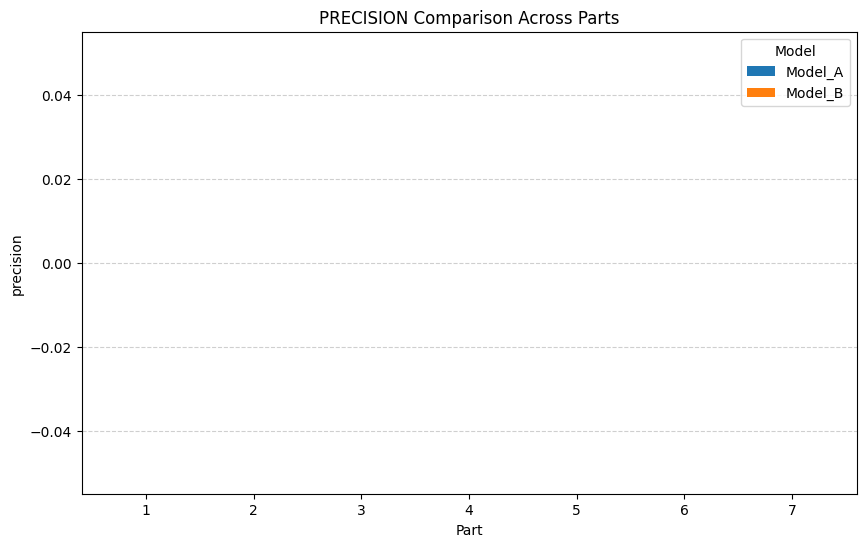

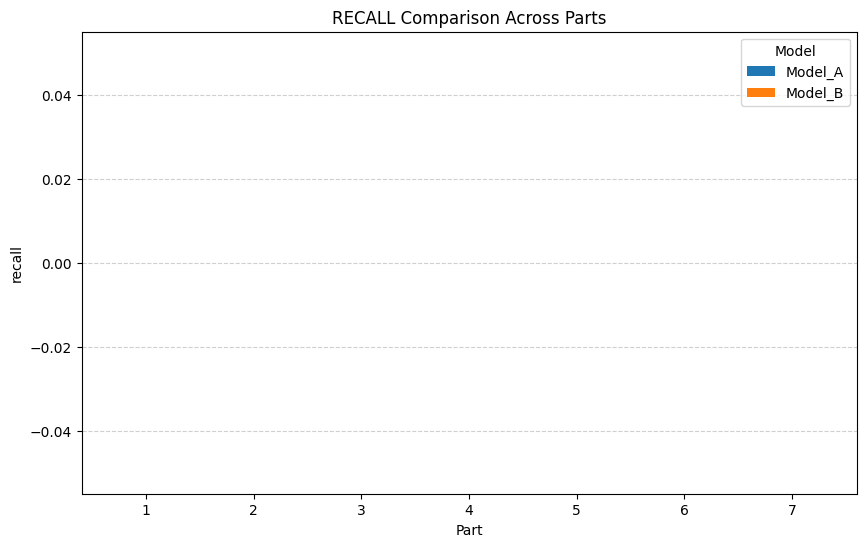

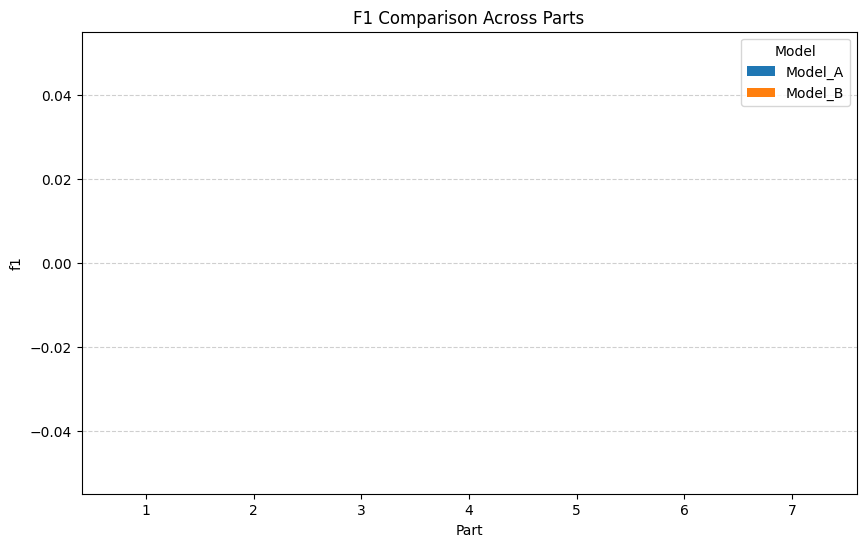

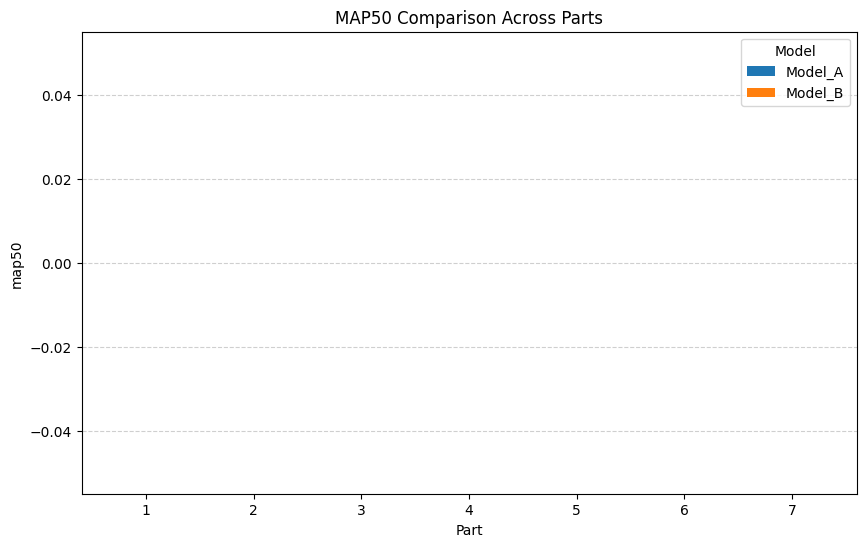

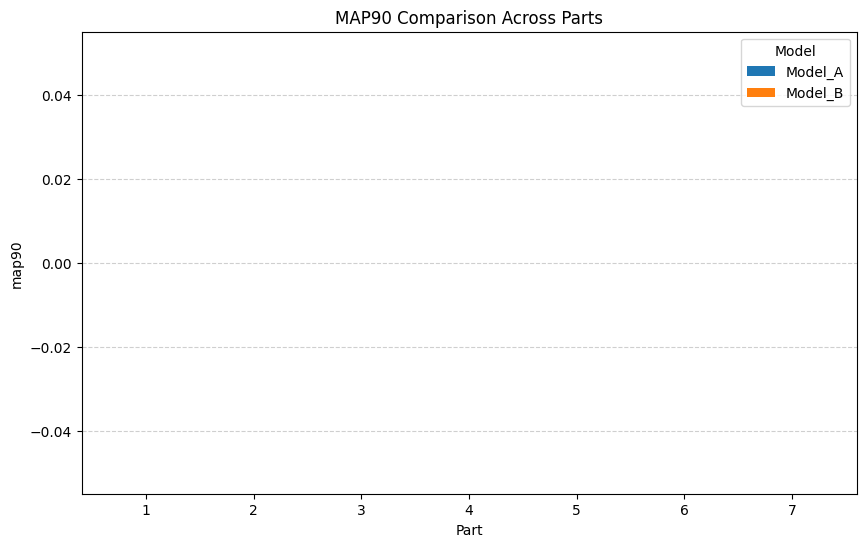

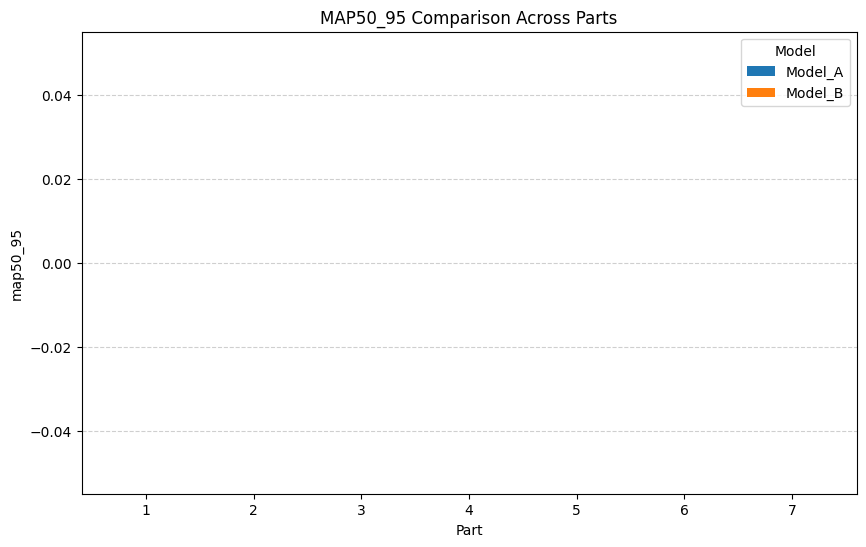

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
LABEL_DIR = "data/bdd100k/labels/train"
MODEL_PRED_DIRS = {
    "Model_A": "runs_artifact/knowledge_05_18:12:55_n_1/inferences",
    "Model_B": "runs_artifact/knowledge_05_16:08:39_n_retrain_1/inferences",
}
CONFIDENCE_THRESHOLD_FOR_P_R_F1 = 0.5
# PART_SIZES = [9000, 8500, 10000, 8500, 11500, 12000, 10500]
PART_SIZES = [10000,10000,10000,10000,10000,10000,10000]  # For simplicity in this example

# --- HELPER FUNCTIONS ---

def yolo_to_corners(box):
    x_center, y_center, w, h = box
    return np.array([x_center - w/2, y_center - h/2, x_center + w/2, y_center + h/2])

def calculate_iou(box1_yolo, box2_yolo):
    box1, box2 = yolo_to_corners(box1_yolo), yolo_to_corners(box2_yolo)
    inter_x1, inter_y1 = max(box1[0], box2[0]), max(box1[1], box2[1])
    inter_x2, inter_y2 = min(box1[2], box2[2]), min(box1[3], box2[3])
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    if inter_area == 0: return 0.0
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    return inter_area / (box1_area + box2_area - inter_area)

def read_boxes(filepath, with_conf=False):
    boxes = []
    if not os.path.exists(filepath): return boxes
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if not parts: continue
            class_id, box_coords = int(parts[0]), [float(p) for p in parts[1:5]]
            if with_conf:
                conf = float(parts[5])
                boxes.append([class_id, conf, box_coords])
            else:
                boxes.append([class_id, box_coords])
    return boxes

def calculate_ap(recall, precision):
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))
    for i in range(len(mpre) - 2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
    i = np.where(mrec[1:] != mrec[:-1])[0]
    return np.sum((mrec[i+1] - mrec[i]) * mpre[i+1])

# --- EVALUATION FUNCTION ---

def evaluate_model_on_files(label_files, pred_dir):
    ground_truths, predictions = defaultdict(list), []
    
    for filename in label_files:
        image_id = filename.split('.')[0]
        # GT
        gt_boxes = read_boxes(os.path.join(LABEL_DIR, filename), with_conf=False)
        for class_id, box in gt_boxes:
            ground_truths[image_id].append({'class_id': class_id, 'box': box, 'used': False})
        # Predictions
        pred_boxes = read_boxes(os.path.join(pred_dir, filename), with_conf=True)
        for class_id, conf, box in pred_boxes:
            predictions.append({'image_id': image_id, 'class_id': class_id, 'confidence': conf, 'box': box})

    if not predictions:
        return dict(precision=0, recall=0, f1=0, map50=0, map90=0, map50_95=0)

    all_gt_classes = {gt['class_id'] for gts in ground_truths.values() for gt in gts}
    all_pred_classes = {p['class_id'] for p in predictions}
    class_ids = sorted(list(all_gt_classes.union(all_pred_classes)))
    iou_thresholds = np.linspace(0.5, 0.95, 10)

    ap_results = defaultdict(dict)
    num_total_gts = sum(len(gts) for gts in ground_truths.values())

    # Compute AP for IoU thresholds
    for iou_thresh in iou_thresholds:
        for gts in ground_truths.values():
            for gt in gts: gt['used'] = False
        predictions.sort(key=lambda x: x['confidence'], reverse=True)
        tps, fps = defaultdict(list), defaultdict(list)
        for pred in predictions:
            image_gts = ground_truths.get(pred['image_id'], [])
            class_gts = [gt for gt in image_gts if gt['class_id'] == pred['class_id']]
            best_iou, best_gt_idx = 0, -1
            for i, gt in enumerate(class_gts):
                iou = calculate_iou(pred['box'], gt['box'])
                if iou > best_iou: best_iou, best_gt_idx = iou, i
            if best_iou >= iou_thresh and best_gt_idx != -1 and not class_gts[best_gt_idx]['used']:
                tps[pred['class_id']].append(1); fps[pred['class_id']].append(0)
                class_gts[best_gt_idx]['used'] = True
            else:
                tps[pred['class_id']].append(0); fps[pred['class_id']].append(1)

        for cid in class_ids:
            num_gt_for_class = sum(1 for gts in ground_truths.values() for gt in gts if gt['class_id'] == cid)
            if num_gt_for_class == 0: ap_results[cid][iou_thresh] = 0.0; continue
            class_tps, class_fps = np.array(tps[cid]), np.array(fps[cid])
            cum_tps, cum_fps = np.cumsum(class_tps), np.cumsum(class_fps)
            recall = cum_tps / num_gt_for_class
            precision = cum_tps / (cum_tps + cum_fps + 1e-9)
            ap_results[cid][iou_thresh] = calculate_ap(recall, precision)

    preds_above_conf = [p for p in predictions if p['confidence'] >= CONFIDENCE_THRESHOLD_FOR_P_R_F1]
    for gts in ground_truths.values():
        for gt in gts: gt['used'] = False
    total_tp, total_fp = 0, 0
    for pred in preds_above_conf:
        image_gts = ground_truths.get(pred['image_id'], [])
        class_gts = [gt for gt in image_gts if gt['class_id'] == pred['class_id']]
        best_iou, best_gt_idx = 0, -1
        for i, gt in enumerate(class_gts):
            iou = calculate_iou(pred['box'], gt['box'])
            if iou > best_iou: best_iou, best_gt_idx = iou, i
        if best_iou >= 0.5 and best_gt_idx != -1 and not class_gts[best_gt_idx]['used']:
            total_tp += 1; class_gts[best_gt_idx]['used'] = True
        else: total_fp += 1
    total_fn = num_total_gts - total_tp

    precision = total_tp / (total_tp + total_fp + 1e-9)
    recall = total_tp / (total_tp + total_fn + 1e-9)
    f1 = 2*precision*recall / (precision+recall+1e-9)

    map50 = np.mean([ap_results[cid][0.5] for cid in class_ids]) if class_ids else 0
    closest_iou_90 = min(iou_thresholds, key=lambda x: abs(x - 0.9))
    map50_95 = np.mean([ap_results[cid][iou] for cid in class_ids for iou in iou_thresholds]) if class_ids else 0

    return dict(precision=precision, recall=recall, f1=f1, map50=map50, map50_95=map50_95)

# --- MAIN LOOP ---

all_label_files = sorted([f for f in os.listdir(LABEL_DIR) if f.endswith('.txt')])
results = []

start = 0
for part_idx, size in enumerate(PART_SIZES, start=1):
    part_files = all_label_files[start:start+size]
    start += size
    print(f"\n=== Evaluating Part {part_idx} ({len(part_files)} images) ===")
    for model_name, pred_dir in MODEL_PRED_DIRS.items():
        metrics = evaluate_model_on_files(part_files, pred_dir)
        metrics.update({"Model": model_name, "Part": part_idx})
        results.append(metrics)

df = pd.DataFrame(results)
display(df)

# --- PLOTTING ---

metrics_to_plot = ["precision", "recall", "f1", "map50", "map90", "map50_95"]
for metric in metrics_to_plot:
    plt.figure(figsize=(10,6))
    pivot = df.pivot(index="Part", columns="Model", values=metric)
    pivot.plot(kind="bar", ax=plt.gca(), width=0.7)
    plt.title(f"{metric.upper()} Comparison Across Parts")
    plt.ylabel(metric)
    plt.xticks(rotation=0)
    plt.legend(title="Model")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()


In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict

# --- CONFIGURATION ---
LABEL_DIR = "data/bdd100k/labels/train"
RUNS_DIR = "runs_artifact"
CONFIDENCE_THRESHOLD_FOR_P_R_F1 = 0.5

# --- HELPER FUNCTIONS (from your evaluation script) ---

def yolo_to_corners(box):
    x_center, y_center, w, h = box
    return np.array([x_center - w/2, y_center - h/2, x_center + w/2, y_center + h/2])

def calculate_iou(box1_yolo, box2_yolo):
    box1 = yolo_to_corners(box1_yolo)
    box2 = yolo_to_corners(box2_yolo)
    inter_x1 = max(box1[0], box2[0])
    inter_y1 = max(box1[1], box2[1])
    inter_x2 = min(box1[2], box2[2])
    inter_y2 = min(box1[3], box2[3])
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    if inter_area == 0: return 0.0
    box1_area = (box1[2]-box1[0])*(box1[3]-box1[1])
    box2_area = (box2[2]-box2[0])*(box2[3]-box2[1])
    return inter_area / (box1_area + box2_area - inter_area)

def read_boxes(filepath, with_conf=False):
    boxes = []
    if not os.path.exists(filepath): return boxes
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if not parts: continue
            class_id = int(parts[0])
            box_coords = [float(p) for p in parts[1:5]]
            if with_conf:
                conf = float(parts[5])
                boxes.append([class_id, conf, box_coords])
            else:
                boxes.append([class_id, box_coords])
    return boxes

def calculate_ap(recall, precision):
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))
    for i in range(len(mpre)-2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
    i = np.where(mrec[1:] != mrec[:-1])[0]
    return np.sum((mrec[i+1] - mrec[i]) * mpre[i+1])

# --- MAIN EVALUATION FUNCTION ---

def evaluate_run(pred_dir):
    ground_truths = defaultdict(list)
    predictions = []

    label_files = [f for f in os.listdir(LABEL_DIR) if f.endswith('.txt')]
    for filename in label_files:
        image_id = filename.split('.')[0]
        gt_boxes = read_boxes(os.path.join(LABEL_DIR, filename), with_conf=False)
        for class_id, box in gt_boxes:
            ground_truths[image_id].append({'class_id': class_id, 'box': box, 'used': False})
        pred_boxes = read_boxes(os.path.join(pred_dir, filename), with_conf=True)
        for class_id, conf, box in pred_boxes:
            predictions.append({'image_id': image_id, 'class_id': class_id, 'confidence': conf, 'box': box})

    all_gt_classes = {gt['class_id'] for gts in ground_truths.values() for gt in gts}
    all_pred_classes = {p['class_id'] for p in predictions}
    class_ids = sorted(list(all_gt_classes.union(all_pred_classes)))
    if not class_ids: 
        return None

    iou_thresholds = np.linspace(0.5, 0.95, 10)
    ap_results = defaultdict(dict)

    # Overall PRF1 stats
    total_tp_50, total_fp_50 = 0, 0

    for iou_thresh in iou_thresholds:
        for gts in ground_truths.values():
            for gt in gts: gt['used'] = False
        predictions.sort(key=lambda x: x['confidence'], reverse=True)
        tps, fps = defaultdict(list), defaultdict(list)

        for pred in predictions:
            image_gts = ground_truths.get(pred['image_id'], [])
            class_gts = [gt for gt in image_gts if gt['class_id'] == pred['class_id']]
            best_iou, best_idx = 0, -1
            for i, gt in enumerate(class_gts):
                iou = calculate_iou(pred['box'], gt['box'])
                if iou > best_iou:
                    best_iou, best_idx = iou, i
            if best_iou >= iou_thresh and best_idx != -1 and not class_gts[best_idx]['used']:
                tps[pred['class_id']].append(1)
                fps[pred['class_id']].append(0)
                class_gts[best_idx]['used'] = True
            else:
                tps[pred['class_id']].append(0)
                fps[pred['class_id']].append(1)

        for cid in class_ids:
            num_gt = sum(1 for gts in ground_truths.values() for gt in gts if gt['class_id']==cid)
            if num_gt == 0:
                ap_results[cid][iou_thresh] = 0.0
                continue
            class_tps = np.array(tps[cid])
            class_fps = np.array(fps[cid])
            cum_tps = np.cumsum(class_tps)
            cum_fps = np.cumsum(class_fps)
            recall = cum_tps / num_gt
            precision = cum_tps / (cum_tps + cum_fps)
            ap_results[cid][iou_thresh] = calculate_ap(recall, precision)

    # P, R, F1 @ IoU=0.5
    num_total_gts = sum(len(gts) for gts in ground_truths.values())
    preds_above_conf = [p for p in predictions if p['confidence'] >= CONFIDENCE_THRESHOLD_FOR_P_R_F1]
    for gts in ground_truths.values():
        for gt in gts: gt['used'] = False
    for pred in preds_above_conf:
        image_gts = ground_truths.get(pred['image_id'], [])
        class_gts = [gt for gt in image_gts if gt['class_id']==pred['class_id']]
        best_iou, best_idx = 0, -1
        for i, gt in enumerate(class_gts):
            iou = calculate_iou(pred['box'], gt['box'])
            if iou > best_iou:
                best_iou, best_idx = iou, i
        if best_iou >= 0.5 and best_idx != -1 and not class_gts[best_idx]['used']:
            total_tp_50 += 1
            class_gts[best_idx]['used'] = True
        else:
            total_fp_50 += 1
    total_fn_50 = num_total_gts - total_tp_50
    avg_precision = total_tp_50/(total_tp_50+total_fp_50) if (total_tp_50+total_fp_50)>0 else 0.0
    avg_recall = total_tp_50/(total_tp_50+total_fn_50) if (total_tp_50+total_fn_50)>0 else 0.0
    avg_f1 = 2*(avg_precision*avg_recall)/(avg_precision+avg_recall) if (avg_precision+avg_recall)>0 else 0.0

    map50 = np.mean([ap_results[cid][0.5] for cid in class_ids])
    closest_iou_90 = min(iou_thresholds, key=lambda x: abs(x - 0.9))
    map90 = np.mean([ap_results[cid][closest_iou_90] for cid in class_ids]) if class_ids else 0
    map5095 = np.mean([ap_results[cid][iou] for cid in class_ids for iou in iou_thresholds])

    return avg_precision, avg_recall, avg_f1, map50, map90, map5095

# --- LOOP OVER RUNS ---

# results = []
# for run_dir in os.listdir(RUNS_DIR):
#     pred_dir = os.path.join(RUNS_DIR, run_dir, "inferences")
#     csv_file = os.path.join(RUNS_DIR, run_dir, "predictions.csv")
#     if not os.path.exists(pred_dir): continue

#     metrics = evaluate_run(pred_dir)
#     if metrics is None: continue
#     avg_precision, avg_recall, avg_f1, map50, map90, map5095 = metrics

#     if os.path.exists(csv_file):
#         df_csv = pd.read_csv(csv_file)
#         avg_conf = df_csv["confidence"].mean()
#         avg_inf_time = df_csv["inference_time"].mean()
#         total_energy = df_csv["energy_uJ"].sum()
#     else:
#         avg_conf = avg_inf_time = total_energy = None

#     results.append({
#         "run": run_dir,
#         "Precision": avg_precision,
#         "Recall": avg_recall,
#         "F1-Score": avg_f1,
#         "mAP@50": map50,
#         "mAP@90": map90,
#         "mAP@50:95": map5095,
#         "Avg Confidence": avg_conf,
#         "Avg Inference Time (s)": avg_inf_time,
#         "Total Energy (uJ)": total_energy
#     })

# results_df = pd.DataFrame(results)
# results_df


In [2]:
import os
import csv
import numpy as np
from tqdm import tqdm
from collections import defaultdict

LABEL_DIR = "data/bdd100k/labels/train"
RUNS_DIR = "runs_artifact"
CONFIDENCE_THRESHOLD_FOR_P_R_F1 = 0.5


# --- Existing helper functions (yolo_to_corners, calculate_iou, read_boxes, calculate_ap) remain unchanged ---


def evaluate_run(pred_dir):
    """Evaluate a single run's predictions and return metrics tuple."""
    ground_truths = defaultdict(list)
    predictions = []

    label_files = [f for f in os.listdir(LABEL_DIR) if f.endswith(".txt")]
    if not label_files:
        print(f"Error: No label files found in {LABEL_DIR}. Aborting.")
        return None

    for filename in label_files:
        image_id = filename.split(".")[0]

        # Ground truths
        gt_boxes = read_boxes(os.path.join(LABEL_DIR, filename), with_conf=False)
        for class_id, box in gt_boxes:
            ground_truths[image_id].append({"class_id": class_id, "box": box, "used": False})

        # Predictions
        pred_boxes = read_boxes(os.path.join(pred_dir, filename), with_conf=True)
        for class_id, conf, box in pred_boxes:
            predictions.append({"image_id": image_id, "class_id": class_id, "confidence": conf, "box": box})

    all_gt_classes = {gt["class_id"] for gts in ground_truths.values() for gt in gts}
    all_pred_classes = {p["class_id"] for p in predictions}
    class_ids = sorted(list(all_gt_classes.union(all_pred_classes)))
    if not class_ids:
        print("Error: No classes found in labels or predictions.")
        return None

    iou_thresholds = np.linspace(0.5, 0.95, 10)
    ap_results = defaultdict(dict)

    # Global stats for overall P/R/F1
    total_tp_50 = total_fp_50 = total_fn_50 = 0

    for iou_thresh in iou_thresholds:
        # Reset GTs
        for gts in ground_truths.values():
            for gt in gts:
                gt["used"] = False

        # Sort predictions by confidence
        predictions.sort(key=lambda x: x["confidence"], reverse=True)

        tps = defaultdict(list)
        fps = defaultdict(list)

        for pred in predictions:
            image_gts = ground_truths.get(pred["image_id"], [])
            class_gts = [gt for gt in image_gts if gt["class_id"] == pred["class_id"]]

            best_iou = 0
            best_gt_idx = -1
            for i, gt in enumerate(class_gts):
                iou = calculate_iou(pred["box"], gt["box"])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = i

            if best_iou >= iou_thresh and best_gt_idx != -1 and not class_gts[best_gt_idx]["used"]:
                tps[pred["class_id"]].append(1)
                fps[pred["class_id"]].append(0)
                class_gts[best_gt_idx]["used"] = True
            else:
                tps[pred["class_id"]].append(0)
                fps[pred["class_id"]].append(1)

        for cid in class_ids:
            num_gt = sum(1 for gts in ground_truths.values() for gt in gts if gt["class_id"] == cid)
            if num_gt == 0:
                ap_results[cid][round(iou_thresh, 2)] = 0.0
                continue

            class_tps = np.array(tps[cid])
            class_fps = np.array(fps[cid])

            cum_tps = np.cumsum(class_tps)
            cum_fps = np.cumsum(class_fps)

            recall = cum_tps / num_gt
            precision = cum_tps / (cum_tps + cum_fps + 1e-9)

            ap = calculate_ap(recall, precision)
            ap_results[cid][round(iou_thresh, 2)] = ap

    # Overall metrics at IoU=0.5 and fixed conf
    num_total_gts = sum(len(gts) for gts in ground_truths.values())
    preds_above_conf = [p for p in predictions if p["confidence"] >= CONFIDENCE_THRESHOLD_FOR_P_R_F1]

    for gts in ground_truths.values():
        for gt in gts:
            gt["used"] = False

    for pred in preds_above_conf:
        image_gts = ground_truths.get(pred["image_id"], [])
        class_gts = [gt for gt in image_gts if gt["class_id"] == pred["class_id"]]
        best_iou = 0
        best_gt_idx = -1
        for i, gt in enumerate(class_gts):
            iou = calculate_iou(pred["box"], gt["box"])
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = i
        if best_iou >= 0.5 and best_gt_idx != -1 and not class_gts[best_gt_idx]["used"]:
            total_tp_50 += 1
            class_gts[best_gt_idx]["used"] = True
        else:
            total_fp_50 += 1

    total_fn_50 = num_total_gts - total_tp_50

    avg_precision = total_tp_50 / (total_tp_50 + total_fp_50) if (total_tp_50 + total_fp_50) > 0 else 0.0
    avg_recall = total_tp_50 / (total_tp_50 + total_fn_50) if (total_tp_50 + total_fn_50) > 0 else 0.0
    avg_f1 = 2 * (avg_precision * avg_recall) / (avg_precision+avg_recall)
    map50 = np.mean([ap_results[cid][0.50] for cid in class_ids])
    map5095 = np.mean([ap_results[cid][iou] for cid in class_ids for iou in ap_results[cid]])

    return avg_precision, avg_recall, avg_f1, map50, map5095


def main():
    run_dirs = [d for d in os.listdir(RUNS_DIR) if os.path.isdir(os.path.join(RUNS_DIR, d))]
    for run_dir in tqdm(run_dirs, desc="Evaluating runs"):
        pred_dir = os.path.join(RUNS_DIR, run_dir, "inferences")
        result_csv = os.path.join(RUNS_DIR, run_dir, "performance_results.csv")

        if os.path.exists(result_csv):
            print(f"Skipping {run_dir}, results already exist.")
            continue
        else:
            print(f"Running {run_dir}, results dont exist.")
        if not os.path.exists(pred_dir):
            continue

        metrics = evaluate_run(pred_dir)
        if metrics is None:
            continue

        avg_precision, avg_recall, avg_f1, map50, map5095 = metrics

        with open(result_csv, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["precision", "recall", "f1", "map50", "map50_95"])
            writer.writerow([avg_precision, avg_recall, avg_f1, map50, map5095])

        print(f"Saved results for {run_dir} -> {result_csv}")

if __name__ == "__main__":
    main()


Evaluating runs:   0%|          | 0/13 [00:00<?, ?it/s]

Skipping knowledge_18_14:09:18_n_prt, results already exist.
Running knowledge_20_09:55:15_harmone3, results dont exist.


Evaluating runs:  15%|█▌        | 2/13 [03:58<21:52, 119.33s/it]

Saved results for knowledge_20_09:55:15_harmone3 -> runs_artifact/knowledge_20_09:55:15_harmone3/performance_results.csv
Skipping knowledge_17_16:49:24_switch, results already exist.
Skipping knowledge_19_06:43:49_harmone2, results already exist.
Skipping knowledge_17_13:16:43_S_1, results already exist.
Skipping knowledge_18_23:04:33_harmone1, results already exist.
Skipping knowledge_18_10:36:02_m_prt, results already exist.
Skipping knowledge_18_18:48:42_s_prt, results already exist.
Skipping knowledge_17_07:31:13_M_1, results already exist.
Skipping knowledge_17_09:39:45_N_1, results already exist.
Skipping knowledge_17_23:21:47_switchretrain, results already exist.
Skipping knowledge_19_22:18:43_harm, results already exist.
Running knowledge_19_22:22:01, results dont exist.


Evaluating runs: 100%|██████████| 13/13 [04:05<00:00, 18.88s/it]

Saved results for knowledge_19_22:22:01 -> runs_artifact/knowledge_19_22:22:01/performance_results.csv


In [6]:
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt

RUNS_DIR = "runs_artifact"


def collect_results():
    rows = []
    run_dirs = [d for d in os.listdir(RUNS_DIR) if os.path.isdir(os.path.join(RUNS_DIR, d))]
    for run_dir in run_dirs:
        result_csv = os.path.join(RUNS_DIR, run_dir, "performance_results.csv")
        if not os.path.exists(result_csv):
            continue

        with open(result_csv, "r") as f:
            reader = csv.DictReader(f)
            for row in reader:
                row["run"] = run_dir
                rows.append(row)

    return pd.DataFrame(rows)


def collect_predictions():
    """Collect and compute averages for confidence, inference_time, energy_uJ per run"""
    rows = []
    run_dirs = [d for d in os.listdir(RUNS_DIR) if os.path.isdir(os.path.join(RUNS_DIR, d))]
    for run_dir in run_dirs:
        pred_csv = os.path.join(RUNS_DIR, run_dir, "predictions.csv")
        if not os.path.exists(pred_csv):
            continue

        df = pd.read_csv(pred_csv)
        avg_conf = df["confidence"].astype(float).mean()
        avg_time = df["inference_time"].astype(float).mean()
        avg_energy = df["energy_uJ"].astype(float).mean()

        rows.append({
            "run": run_dir,
            "avg_confidence": avg_conf,
            "avg_inference_time": avg_time,
            "avg_energy_uJ": avg_energy
        })

    return pd.DataFrame(rows)


def plot_metrics(df):
    metrics = ["precision", "recall", "f1", "map50", "map50_95"]

    for metric in metrics:
        plt.figure(figsize=(10, 5))
        df_sorted = df.sort_values(by=metric, ascending=False)
        plt.bar(df_sorted["run"], df_sorted[metric].astype(float))
        plt.title(f"{metric.upper()} across runs")
        plt.xlabel("Run")
        plt.ylabel(metric)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig(os.path.join(RUNS_DIR, f"{metric}_comparison.png"))
        plt.close()
        print(f"Saved plot: {metric}_comparison.png")


def plot_predictions(df):
    metrics = ["avg_confidence", "avg_inference_time", "avg_energy_uJ"]

    for metric in metrics:
        plt.figure(figsize=(10, 5))
        df_sorted = df.sort_values(by=metric, ascending=False)
        plt.bar(df_sorted["run"], df_sorted[metric].astype(float))
        plt.title(f"{metric.replace('_', ' ').title()} across runs")
        plt.xlabel("Run")
        plt.ylabel(metric.replace("_", " "))
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig(os.path.join(RUNS_DIR, f"{metric}_comparison.png"))
        plt.close()
        print(f"Saved plot: {metric}_comparison.png")


def main():
    # Collect and save performance results
    df = collect_results()
    if not df.empty:
        summary_csv = os.path.join(RUNS_DIR, "summary_results.csv")
        df.to_csv(summary_csv, index=False)
        print(f"Saved summary: {summary_csv}")
        plot_metrics(df)
    else:
        print("No performance_results.csv found in runs.")

    # Collect and save prediction averages
    df_pred = collect_predictions()
    if not df_pred.empty:
        summary_pred_csv = os.path.join(RUNS_DIR, "summary_predictions.csv")
        df_pred.to_csv(summary_pred_csv, index=False)
        print(f"Saved prediction summary: {summary_pred_csv}")
        plot_predictions(df_pred)
    else:
        print("No predictions.csv found in runs.")


if __name__ == "__main__":
    main()


Saved summary: runs_artifact/summary_results.csv
Saved plot: precision_comparison.png
Saved plot: recall_comparison.png
Saved plot: f1_comparison.png
Saved plot: map50_comparison.png
Saved plot: map50_95_comparison.png
Saved prediction summary: runs_artifact/summary_predictions.csv
Saved plot: avg_confidence_comparison.png
Saved plot: avg_inference_time_comparison.png
Saved plot: avg_energy_uJ_comparison.png
